In [1]:
# Note by XO on 03/07/2022: This is an HDBSCAN clustering result analysis script. 
# We stack the realizations together and simply count for each star, how many times it is clustered into some cluster
# Start from there
# Import libraries
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, Normalize, LogNorm
from scipy.interpolate import interpn
import seaborn as sns

cmap = ListedColormap(sns.color_palette("colorblind",60))
pal = sns.color_palette('colorblind', 60)

import astropy.coordinates as coord
import astropy.units as u

label_size = 24
matplotlib.rc('font', size=label_size) 

from collections import Counter

import sklearn
# print(sklearn.__version__)
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import hdbscan

import warnings
warnings.filterwarnings("once")

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
# Define a function to plot the clusters means
def plot_clusters(means, dispersions, x_label, y_label, xlim_l, xlim_u, ylim_l, ylim_u, c_list,
                  add_data=[], add_err=[], add_c_list=[],
                  fig_size = [4,1], n_dim = 3, n_row = 1, n_col = 3, 
                  x_ax = [0,0,2], y_ax = [1,2,1], 
                  err_bar = True, f_name=None):
    assert (len(means[0]) == len(dispersions[0])) and (len(means[0]) == len(x_label)) and (len(y_label) == len(x_label))
    
    f = plt.figure(figsize=fig_size)
    
    for i in range(n_row):
        for j in range(n_col):
            k = i+j
            plt.subplot(n_row, n_col, k+1)
            if err_bar == True:
                plt.errorbar(x=means[:,x_ax[k]], y=means[:,y_ax[k]], xerr=dispersions[:,x_ax[k]], yerr=dispersions[:,y_ax[k]],
                             linestyle='none',c=c_list,markersize=10)
                if len(add_data) != 0 and len(add_err) != 0:
                    plt.errorbar(x=add_data[:,x_ax[k]], y=add_data[:,y_ax[k]], xerr=add_err[:,x_ax[k]], yerr=add_err[:,y_ax[k]],
                                 linestyle='none',c=add_c_list,markersize=5)
                elif len(add_data) != 0 and len(add_err) == 0: 
                    plt.scatter(x=add_data[:,x_ax[k]], y=add_data[:,y_ax[k]],c=add_c_list,s=5)
            else:
                plt.scatter(x=means[:,x_ax[k]], y=means[:,y_ax[k]],c=c_list,s=10)
                if len(add_data) != 0:
                    plt.scatter(x=add_data[:,x_ax[k]], y=add_data[:,y_ax[k]],c=add_c_list,s=5)
                
            plt.xlabel(x_label[k])
            plt.ylabel(y_label[k])
            plt.xlim([xlim_l[k],xlim_u[k]])
            plt.ylim([ylim_l[k],ylim_u[k]])
    
    plt.tight_layout()
    
    if f_name != None:
        f.savefig(f_name)
    
    plt.show()
            

In [4]:
# Define a plotting funciton for plotting specific lists of stars in all relevant spaces
def plot_summary_v3(df_vel,df_orb,ind_list,c_list,title,legends,list_mask=False,filename=None,bg=False,ds=True,noise=True,ind_add_cut=[]):
    if len(ind_add_cut) == 0 and list_mask == True:
        ind_add_cut = ind_cut
    
    f = plt.figure(figsize=[30,40])
    
#     plt.suptitle(title)
    
    # Set the plotting parameters
    plt.subplot(4,3,1)
    plt.xlim([-4.5e3,4.5e3])
    plt.ylim([-1.7e5,0.1e5])
    plt.xlabel(r'$L_z$ [kpc km s$^{-1}$]')
    plt.ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')
    
    # Make a fake dot for the legend
    # Adjusted the auto-legend setting to always make stars for clusters and dots for noises
    for i in range(len(ind_list)):
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)) and bg == False:  
            mkr='*'
            ec='k'
        else:
            mkr='.'
            ec=c_list[i][0]
        try:
            # Check if needs downsampling; if so, flag it in legend
            if len(ind_list[i]) > 5000 and ds == True:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i]+'_sp',marker=mkr,edgecolors=ec)
            else:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i],marker=mkr,edgecolors=ec)
        except IndexError:
            print("Cluster number:",legends[i],'has zero stars.')
#     plt.legend(fontsize='small')
    
    plt.subplot(4,3,2)
    plt.xlim([3000,13000])
    plt.ylim([-5000,5000])
    plt.xlabel(r'$r_{gal}$ [pc]')
    plt.ylabel('Z [pc]')
    
    plt.subplot(4,3,3)
    plt.xlim([0,26000])
    plt.ylim([0,26000])
    plt.xlabel(r'$r_{peri}$ [pc]')
    plt.ylabel(r'$r_{apo}$ [pc]')
    
    plt.subplot(4,3,4)
    plt.xlim([-600,600])
    plt.ylim([-600,600])
    plt.xlabel(r'$v_{r}$ [km/s]')
    plt.ylabel(r'$v_{\phi}$ [km/s]')
    
    plt.subplot(4,3,5)
    plt.xlim([-600,600])
    plt.ylim([-600,600])
    plt.xlabel(r'$v_{r}$ [km/s]')
    plt.ylabel(r'$v_{z}$ [km/s]')
    
    plt.subplot(4,3,6)
    plt.xlim([0,1])
    plt.xlabel(r'Ecc [Unitless]')
    plt.ylabel(r'$N$')
    
    plt.subplot(4,3,7)
    plt.xlim([0,1])
    plt.ylim([1000,5000])
    plt.xlabel('Ecc [unitless]')
    plt.ylabel('Zmax [pc]')
    
    plt.subplot(4,3,8)
    plt.xlabel(r'$J_{\phi}/J_{tot}$ [kpc km/s]')
    plt.ylabel(r'$(J_z-J_R)/J_{tot}$ [kpc km/s]')
    
    plt.subplot(4,3,9)
    plt.xlim([-3.1,1.0])
    plt.ylim([-0.21,0.61])
    plt.xlabel('[Fe/H] [dex]')
    plt.ylabel(r'[$\alpha$/Fe] [dex]')
    
    plt.subplot(4,3,10)
    plt.xlim([0, 4500])
    plt.ylim([-4500, 4500])
    plt.xlabel(r'$J_R$ [kpc km/s]')
    plt.ylabel(r'$J_{\phi}$ [kpc km/s]')
    
    plt.subplot(4,3,11)
    plt.xlim([0, 4500])
    plt.ylim([0, 4500])
    plt.xlabel(r'$J_R$ [kpc km/s]')
    plt.ylabel(r'$J_z$ [kpc km/s]')
    
    plt.subplot(4,3,12)
    plt.xlim([-3.1,1.0])
    plt.xlabel(r'[Fe/H] [dex]')
    plt.ylabel(r'$N$')
    
    for i in range(len(ind_list)):
        if list_mask == True:
            ind = ind_add_cut[ind_list[i]]
        else:
            ind = ind_list[i]
        color = c_list[i]
        
            
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)) and bg == False:
            mkr='*'
            ms=50
            al=1 
#             ec=['k']*len(ind)
            ec='none'
            zord=i
        else:
            mkr='.'
            ms=20
            al=0.3
            ec='none'
            zord=-1
        
        # Determine if there are more than 10000 data points, if so, down-sample it
        if len(ind) > 5000 and ds == True:
            ii = np.random.choice(len(ind),int(len(ind)/20),replace=False)
            ind = ind[ii]
            
            # Check to see if color list also needs to be downsampled
            if len(color) > len(ind): 
                color = color[ii]
        
        # Plot E vs. Lz
        plt.subplot(4,3,1)
        plt.scatter(df_orb.loc[ind,'Lz'],df_orb.loc[ind,'Etot'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        # Plot Z vs. r_gal
        plt.subplot(4,3,2)
        plt.scatter(np.sqrt(df_vel.loc[ind,'XGC']**2+df_vel.loc[ind,'YGC']**2),df_vel.loc[ind,'ZGC'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        # Plot apo vs. peri
        plt.subplot(4,3,3)
        plt.scatter(df_orb.loc[ind,'peri'],df_orb.loc[ind,'apo'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot vphi vs. vr
        plt.subplot(4,3,4)
        plt.scatter(df_vel.loc[ind,'vr_g2'],df_vel.loc[ind,'vphi_g2'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot vz vs. vr
        plt.subplot(4,3,5)
        plt.scatter(df_vel.loc[ind,'vr_g2'],df_vel.loc[ind,'vz_g2'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot 1d Ecc histogram: skip the noise
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)):
            plt.subplot(4,3,6)
            plt.hist(df_orb.loc[ind,'ecc'],histtype='step',bins=np.arange(0.0,1.05,0.05),color=color[0])
        
        
        # Plot zmax vs. ecc
        plt.subplot(4,3,7)
        plt.scatter(df_orb.loc[ind,'ecc'],df_orb.loc[ind,'zmax'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
    
        # Plot Action diamond
        plt.subplot(4,3,8)
        plt.scatter(df_orb.loc[ind,'diamond_x'],df_orb.loc[ind,'diamond_y'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot Alpha vs. [Fe/H]
        plt.subplot(4,3,9)
        plt.scatter(df_vel.loc[ind,'m_h_ap17'],df_vel.loc[ind,'alpha_m_ap17'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot Jphi vs. JR
        plt.subplot(4,3,10)
        plt.scatter(df_orb.loc[ind,'JR'],df_orb.loc[ind,'Jphi'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot Jz vs. JR
        plt.subplot(4,3,11)
        plt.scatter(df_orb.loc[ind,'JR'],df_orb.loc[ind,'Jz'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot 1d [Fe/H] histogram; skip the noise
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)):
            plt.subplot(4,3,12)
            plt.hist(df_vel.loc[ind,'m_h_mean'],histtype='step',bins=np.arange(-3.1,1.1,0.1),color=color[0])
        
        
    
    f.tight_layout()
    plt.show()
    if filename != None:
        f.savefig(filename,layout='tight')

In [180]:
# Define a plotting funciton for plotting specific lists of stars in all relevant spaces
def plot_summary_v3_kde(df_vel,df_orb,ind_list,c_list,title,legends,list_mask=False,filename=None,bg=False,ds=True,noise=True,ind_add_cut=[]):
    if len(ind_add_cut) == 0 and list_mask == True:
        ind_add_cut = ind_cut
    
    f = plt.figure(figsize=[30,40])
    
#     plt.suptitle(title)
    
    # Set the plotting parameters
    plt.subplot(4,3,1)
    plt.xlim([-4.5e3,4.5e3])
    plt.ylim([-1.7e5,0.1e5])
    plt.xlabel(r'$L_z$ [kpc km s$^{-1}$]')
    plt.ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')
    
    # Make a fake dot for the legend
    # Adjusted the auto-legend setting to always make stars for clusters and dots for noises
    for i in range(len(ind_list)):
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)) and bg == False:  
            mkr='*'
            ec='k'
        else:
            mkr='.'
            ec=c_list[i][0]
        try:
            # Check if needs downsampling; if so, flag it in legend
            if len(ind_list[i]) > 5000 and ds == True:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i]+'_sp',marker=mkr,edgecolors=ec)
            else:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i],marker=mkr,edgecolors=ec)
        except IndexError:
            print("Cluster number:",legends[i],'has zero stars.')
#     plt.legend(fontsize='small')
    
    plt.subplot(4,3,2)
    plt.xlim([3000,13000])
    plt.ylim([-5000,5000])
    plt.xlabel(r'$r_{gal}$ [pc]')
    plt.ylabel('Z [pc]')
    
    plt.subplot(4,3,3)
    plt.xlim([0,16])
    plt.ylim([0,26])
    plt.xlabel(r'$r_{peri}$ [kpc]')
    plt.ylabel(r'$r_{apo}$ [kpc]')
    
    plt.subplot(4,3,4)
    plt.xlim([-600,600])
    plt.ylim([-600,600])
    plt.xlabel(r'$v_{r}$ [km/s]')
    plt.ylabel(r'$v_{\phi}$ [km/s]')
    
    plt.subplot(4,3,5)
    plt.xlim([-600,600])
    plt.ylim([-600,600])
    plt.xlabel(r'$v_{r}$ [km/s]')
    plt.ylabel(r'$v_{z}$ [km/s]')
    
    plt.subplot(4,3,6)
    plt.xlim([0,1])
    plt.xlabel(r'Ecc [Unitless]')
    plt.ylabel(r'$f$(Ecc)')
    
    plt.subplot(4,3,7)
    plt.xlim([0,1])
    plt.ylim([1000,5000])
    plt.xlabel('Ecc [unitless]')
    plt.ylabel('Zmax [pc]')
    
    plt.subplot(4,3,8)
    plt.xlabel(r'$J_{\phi}/J_{tot}$ [kpc km/s]')
    plt.ylabel(r'$(J_z-J_R)/J_{tot}$ [kpc km/s]')
    
    plt.subplot(4,3,9)
    plt.xlim([-3.1,1.0])
    plt.ylim([-0.21,0.61])
    plt.xlabel('[Fe/H] [dex]')
    plt.ylabel(r'[$\alpha$/Fe] [dex]')
    
    plt.subplot(4,3,10)
    plt.xlim([0, 2500])
    plt.ylim([-3800, 3800])
    plt.xlabel(r'$J_R$ [kpc km/s]')
    plt.ylabel(r'$J_{\phi}$ [kpc km/s]')
    
    plt.subplot(4,3,11)
    plt.xlim([0, 2500])
    plt.ylim([0, 2000])
    plt.xlabel(r'$J_R$ [kpc km/s]')
    plt.ylabel(r'$J_z$ [kpc km/s]')
    
    plt.subplot(4,3,12)
    plt.xlim([-3.1,1.0])
    plt.xlabel(r'[Fe/H] [dex]')
    plt.ylabel(r'$f$([Fe/H])')
    
    for i in range(len(ind_list)):
        if list_mask == True:
            ind = ind_add_cut[ind_list[i]]
        else:
            ind = ind_list[i]
        color = c_list[i]
        
            
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)) and bg == False:
            mkr='*'
            ms=50
            al=1 
#             ec=['k']*len(ind)
            ec='none'
            zord=i
        else:
            mkr='.'
            ms=20
            al=0.3
            ec='none'
            zord=-1
        
        # Determine if there are more than some number of data points, if so, down-sample it
        if len(ind) > 5000 and ds == True:
            ii = np.random.choice(len(ind),int(len(ind)/5),replace=False)
            ind = ind[ii]
            
            # Check to see if color list also needs to be downsampled
            if len(color) > len(ind): 
                color = color[ii]
        
        # Plot E vs. Lz
        plt.subplot(4,3,1)
        plt.scatter(df_orb.loc[ind,'Lz'],df_orb.loc[ind,'Etot'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        # Plot Z vs. r_gal
        plt.subplot(4,3,2)
        plt.scatter(np.sqrt(df_vel.loc[ind,'XGC']**2+df_vel.loc[ind,'YGC']**2),df_vel.loc[ind,'ZGC'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        # Plot apo vs. peri
        plt.subplot(4,3,3)
        plt.scatter(df_orb.loc[ind,'peri']/1000,df_orb.loc[ind,'apo']/1000,s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot vphi vs. vr
        plt.subplot(4,3,4)
        plt.scatter(df_vel.loc[ind,'vr_g2'],df_vel.loc[ind,'vphi_g2'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot vz vs. vr
        plt.subplot(4,3,5)
        plt.scatter(df_vel.loc[ind,'vr_g2'],df_vel.loc[ind,'vz_g2'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot 1d Ecc histogram: skip the noise
#         if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)):
        plt.subplot(4,3,6)
#             plt.hist(df_orb.loc[ind,'ecc'],histtype='step',bins=np.arange(0.0,1.05,0.05),color=color[0])
        sns.distplot(df_orb.loc[ind,'ecc'],hist=False,kde=True,bins=np.arange(0.0,1.05,0.05),kde_kws={"color": color[0]})
        # Have to set the x-axis again to overwrite sns auto axis
        plt.xlabel(r'Ecc [Unitless]')
        
        
        # Plot zmax vs. ecc
        plt.subplot(4,3,7)
        plt.scatter(df_orb.loc[ind,'ecc'],df_orb.loc[ind,'zmax'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
    
        # Plot Action diamond
        plt.subplot(4,3,8)
        plt.scatter(df_orb.loc[ind,'diamond_x'],df_orb.loc[ind,'diamond_y'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot Alpha vs. [Fe/H]
        plt.subplot(4,3,9)
        plt.scatter(df_vel.loc[ind,'m_h_ap17'],df_vel.loc[ind,'alpha_m_ap17'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot Jphi vs. JR
        plt.subplot(4,3,10)
        plt.scatter(df_orb.loc[ind,'JR'],df_orb.loc[ind,'Jphi'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot Jz vs. JR
        plt.subplot(4,3,11)
        plt.scatter(df_orb.loc[ind,'JR'],df_orb.loc[ind,'Jz'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot 1d [Fe/H] histogram; skip the noise
#         if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)):
        plt.subplot(4,3,12)
#             plt.hist(df_vel.loc[ind,'m_h_mean'],histtype='step',bins=np.arange(-3.1,1.1,0.1),color=color[0])
        sns.distplot(df_vel.loc[ind,'m_h_mean'],hist=False,kde=True,bins=np.arange(-3.1,1.1,0.1),kde_kws={"color": color[0]})
        plt.xlabel(r'[Fe/H] [dex]')
        
    
    f.tight_layout()
    plt.show()
    if filename != None:
        f.savefig(filename,layout='tight')

In [5]:
# Define a plotting funciton for plotting specific lists of stars in all relevant spaces
def plot_summary_short(df_vel,df_orb,ind_list,c_list,title,legends,list_mask=False,filename=None,bg=False,ds=True,noise=True,ind_add_cut=[]):
    if len(ind_add_cut) == 0 and list_mask == True:
        ind_add_cut = ind_cut
    
    f = plt.figure(figsize=[16,5])
    
#     plt.suptitle(title)
    
    # Set the plotting parameters
    plt.subplot(1,3,1)
    plt.xlim([-600,600])
    plt.ylim([-600,600])
    plt.xlabel(r'$v_{r}$ [km/s]')
    plt.ylabel(r'$v_{\phi}$ [km/s]')
    
    # Make a fake dot for the legend
    # Adjusted the auto-legend setting to always make stars for clusters and dots for noises
    for i in range(len(ind_list)):
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)) and bg == False:  
            mkr='*'
            ec='k'
        else:
            mkr='.'
            ec=c_list[i][0]
        try:
            # Check if needs downsampling; if so, flag it in legend
            if len(ind_list[i]) > 5000 and ds == True:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i]+'_sp',marker=mkr,edgecolors=ec)
            else:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i],marker=mkr,edgecolors=ec)
        except IndexError:
            print("Cluster number:",legends[i],'has zero stars.')
#     plt.legend(fontsize='small')
    
    
    plt.subplot(1,3,2)
    plt.xlim([-600,600])
    plt.ylim([-600,600])
    plt.xlabel(r'$v_{r}$ [km/s]')
    plt.ylabel(r'$v_{z}$ [km/s]')
    
    plt.subplot(1,3,3)
    plt.xlim([-4.5e3,4.5e3])
    plt.ylim([-1.7e5,0.1e5])
    plt.xlabel(r'$J_{\phi}$ [kpc km s$^{-1}$]')
    plt.ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')
    
    
    for i in range(len(ind_list)):
        if list_mask == True:
            ind = ind_add_cut[ind_list[i]]
        else:
            ind = ind_list[i]
        color = c_list[i]
        
            
        if ((i < len(ind_list)-1 or noise == False) or (len(ind_list) == 1)) and bg == False:
            mkr='*'
            ms=20
            al=1 
#             ec=['k']*len(ind)
            ec='none'
            zord=i
        else:
            mkr='.'
            ms=20
            al=0.3
            ec='none'
            zord=-1
        
        # Determine if there are more than 10000 data points, if so, down-sample it
        if len(ind) > 5000 and ds == True:
            ii = np.random.choice(len(ind),int(len(ind)/20),replace=False)
            ind = ind[ii]
            
            # Check to see if color list also needs to be downsampled
            if len(color) > len(ind): 
                color = color[ii]
        
        
        # Plot vphi vs. vr
        plt.subplot(1,3,1)
        plt.scatter(df_vel.loc[ind,'vr_g2'],df_vel.loc[ind,'vphi_g2'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
        
        # Plot vz vs. vr
        plt.subplot(1,3,2)
        plt.scatter(df_vel.loc[ind,'vr_g2'],df_vel.loc[ind,'vz_g2'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
         # Plot E vs. Lz
        plt.subplot(1,3,3)
        plt.scatter(df_orb.loc[ind,'Lz'],df_orb.loc[ind,'Etot'],s=ms,alpha=al,c=color,edgecolors=ec,linewidths=1,marker=mkr,zorder=zord)
        
    
    f.tight_layout()
    plt.show()
    if filename != None:
        f.savefig(filename,layout='tight')

In [6]:
# Write a general function for plotting histogram to examine the distribution
def plot_dist(data_list,label_list,xlabel='',xrange=[],ylog=False,fname=None,**kwargs):
    f = plt.figure(figsize=[10,8])
    
    for i in range(len(data_list)):
        sns.distplot(data_list[i],label=label_list[i],**kwargs)

    plt.legend(fontsize='small')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    if len(xrange) != 0:
        plt.xlim(xrange)
    if ylog:
        plt.yscale('log')
    plt.show()
    
    if fname != None:
        f.savefig(fname,layout='tight')

In [8]:
cm_vel_all.columns

Index(['index', 'source_id', 'ra', 'dec', 'm_h_ap', 'm_h_err_ap', 'm_h_flg_ap',
       'alpha_m_ap', 'alpha_m_err_ap', 'alpha_m_flg_ap', 'm_h_l6s',
       'm_h_err_l6s', 'm_h_flg_l6s', 'alpha_m_l6s', 'alpha_m_err_l6s',
       'alpha_m_flg_l6s', 'm_h_gl3', 'm_h_err_gl3', 'm_h_flg_gl3',
       'alpha_m_gl3', 'alpha_m_err_gl3', 'alpha_m_flg_gl3', 'm_h_r6',
       'alpha_m_r6', 'm_h_err_r6', 'alpha_m_err_r6', 'XGC', 'YGC', 'ZGC',
       'm_h_r6c', 'alpha_m_r6c', 'm_h_err_r6c', 'alpha_m_err_r6c',
       'm_h_flg_r6c', 'alpha_m_flg_r6c', 'qual_flag', 'bin_flag', 'parallax',
       'parallax_error', 'parallax_zpcorr', 'l', 'b', 'XGCerr', 'YGCerr',
       'ZGCerr', 'U_g2', 'Uerr_g2', 'V_g2', 'Verr_g2', 'W_g2', 'Werr_g2',
       'UVcov_g2', 'UWcov_g2', 'VWcov_g2', 'v_forder_g2', 'vr_g2', 'vphi_g2',
       'vz_g2', 'vrerr_g2', 'vphierr_g2', 'vzerr_g2', 'vrphicov_g2',
       'vrzcov_g2', 'vphizcov_g2', 'm_h_ap17', 'm_h_err_ap17', 'alpha_m_ap17',
       'alpha_m_err_ap17', 'aspcap_flg_ap17'],
    

In [7]:
# Import dacombine_first for testing approximate_predict of hdbscan
# Try predicting the stars membership to the cluster of clusters
cm_vel_all = pd.read_hdf('../data/dr3_near_vel_plxzp_g2_only.h5')
orb_param_all = pd.read_hdf('../data/dr3_orb_param_err_g2_only.h5')

# My selection
# cutoff = 3500 # pc
# Pick the stars with reasonable velocities(need to jutify this later)
# and reasoanable metallicity 
# and meet all quality cuts except for the binary cut
# Temporarily ignoring any action flags and not using any action for now
# kin_qual = ((abs(cm_vel_all['U_g2']) < 1000) & 
#             (abs(cm_vel_all['V_g2']) < 1000) & (abs(cm_vel_all['W_g2']) < 1000) & 
#             (cm_vel_all['qual_flag'] == 0) # & 
#            )

# selection = ((orb_param_all['zmax']-2*orb_param_all['e_zmax']) > cutoff)

# combined_cut = kin_qual & selection

# ind_cut = np.where(combined_cut)[0]
# print("Sample size after cut:",len(ind_cut))

# Cut the dataframe
# df_cut_vel = cm_vel_all.loc[ind_cut,:]
# df_cut_orb = orb_param_all.loc[ind_cut,:]

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [9]:
# Set all -9999 values in APOGEE and RAVE6 cnn [Fe/H] and alpha to np.nan for easier calculation later
ind_ap_999 = np.where(cm_vel_all.loc[:,'m_h_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'m_h_r6c'] < -100)[0]
ind_ap17_999 = np.where(cm_vel_all.loc[:,'m_h_ap17'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'m_h_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'m_h_r6c'] = np.nan
cm_vel_all.loc[ind_ap17_999,'m_h_ap17'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'m_h_err_ap'] < -100)[0]
ind_ap17_999 = np.where(cm_vel_all.loc[:,'m_h_err_ap17'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'m_h_err_r6c'] < -100)[0]
ind_l6s_999 = np.where(cm_vel_all.loc[:,'m_h_err_l6s'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'m_h_err_ap'] = np.nan
cm_vel_all.loc[ind_ap17_999,'m_h_err_ap17'] = np.nan
cm_vel_all.loc[ind_r6c_999,'m_h_err_r6c'] = np.nan
cm_vel_all.loc[ind_l6s_999,'m_h_err_l6s'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'alpha_m_ap'] < -100)[0]
ind_ap17_999 = np.where(cm_vel_all.loc[:,'alpha_m_ap17'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'alpha_m_r6c'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'alpha_m_ap'] = np.nan
cm_vel_all.loc[ind_ap17_999,'alpha_m_ap17'] = np.nan
cm_vel_all.loc[ind_r6c_999,'alpha_m_r6c'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_ap'] < -100)[0]
ind_ap17_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_ap17'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_r6c'] < -100)[0]
ind_l6s_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_l6s'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'alpha_m_err_ap'] = np.nan
cm_vel_all.loc[ind_ap17_999,'alpha_m_err_ap17'] = np.nan
cm_vel_all.loc[ind_r6c_999,'alpha_m_err_r6c'] = np.nan
cm_vel_all.loc[ind_l6s_999,'alpha_m_err_l6s'] = np.nan

# ASPCAP flag? Remove them later when making plots. We don't use them for clustering anyway
# bad_bits = 2**23

In [10]:
# calculate the columns for the scaled action diamond
orb_param_all['Jtot'] = np.sqrt(orb_param_all['Jphi']**2+orb_param_all['JR']**2+orb_param_all['Jz']**2)
orb_param_all['diamond_x']=orb_param_all['Jphi']/orb_param_all['Jtot']
orb_param_all['diamond_y']=(orb_param_all['Jz']-orb_param_all['JR'])/orb_param_all['Jtot']

# Calculate the error for Jtot and diamond_x/y
orb_param_all['e_Jtot'] = np.sqrt(orb_param_all['Jphi']**2*orb_param_all['e_Jphi']**2+orb_param_all['JR']**2*orb_param_all['e_JR']**2+orb_param_all['Jz']**2*orb_param_all['e_Jz']**2)/orb_param_all['Jtot']
orb_param_all['e_diamond_x']=np.sqrt(orb_param_all['Jtot']**2*orb_param_all['e_Jphi']**2+orb_param_all['e_Jtot']**2*orb_param_all['Jphi']**2)/orb_param_all['Jtot']**2
orb_param_all['e_diamond_y']=np.sqrt(orb_param_all['Jtot']**2*(orb_param_all['e_JR']**2+orb_param_all['e_Jz']**2)+orb_param_all['e_Jtot']**2*(orb_param_all['Jz']-orb_param_all['JR'])**2)/orb_param_all['Jtot']**2

# Calculate L_perp for clustering
orb_param_all['Lperp'] = np.sqrt(orb_param_all['Lx']**2+orb_param_all['Ly']**2)
orb_param_all['e_Lperp'] = np.sqrt(orb_param_all['Lx']**2*orb_param_all['e_Lx']**2+orb_param_all['Ly']**2*orb_param_all['e_Ly']**2)/orb_param_all['Lperp']

# This mean metallicity below is only used in the case when we actually want to cluster in or with a prior cut on metallicity
# To avoid systematic differences between spectroscopic surveys; don't mix metallicities from different surveys
# cm_vel_all['m_h_mean'] = np.nanmean(cm_vel_all[['m_h_ap17','m_h_l6s','m_h_r6c','m_h_gl3']].values, axis=1).T
cm_vel_all['m_h_mean'], cm_vel_all['e_m_h_mean'] = cm_vel_all['m_h_ap17'], cm_vel_all['m_h_err_ap17'] 

orb_param_all['PCA_X'] = np.empty(len(orb_param_all))*np.nan
orb_param_all['PCA_Y'] = np.empty(len(orb_param_all))*np.nan

In [158]:
# Import data of results from the random resampling clustering
# space = 'E_act'
# space_e = 'act_etot'
space = 'vel_cyl'
space_e = 'vel_cyl'
cut = '2500'


# data_dir = './' + space + '_' + cut + '_data_20_20_err_abs/'
# extratext = '_0217_g2only_err_abs_cut_zmax_cut_' + cut + '_' + space_e + '_hdbscan_min_samples_20_min_clustsize_20_leaf_samp_'

data_dir = './' + space + '_' + cut + '_data_20_20_err_nocut/'
extratext = '_0420_g2only_err_no_cut_zmax_cut_' + cut + '_' + space_e + '_hdbscan_min_samples_20_min_clustsize_20_leaf_samp_'


# cluster_id = np.load(data_dir + 'member_gedr3id' + extratext + '.npy',allow_pickle=True)
# cluster_ind = np.load(data_dir + 'member_mask' + extratext + '.npy',allow_pickle=True)
# cluster_col = np.load(data_dir + 'color' + extratext + '.npy',allow_pickle=True)
# cluster_nstar = np.load(data_dir + 'member_nstar' + extratext + '.npy',allow_pickle=True)
# cluster_means = np.load(data_dir + 'member_means' + extratext + '.npy',allow_pickle=True)
# cluster_dispersions = np.load(data_dir + 'member_disps' + extratext + '.npy',allow_pickle=True)

N_samp = 100

# Find all the files
samp_list = np.arange(N_samp,dtype=int)
cluster_id_path_list = []
cluster_ind_path_list = []
mean_path_list = []
disp_path_list = []
nstar_path_list = []


for i in range(N_samp):
    cluster_id_file_name = glob.glob(data_dir+'member_gedr3id'+ extratext + str(samp_list[i])+'.npy')[0]
    cluster_ind_file_name = glob.glob(data_dir+'member_mask'+ extratext + str(samp_list[i])+'.npy')[0]
    mean_file_name = glob.glob(data_dir+'member_means'+ extratext + str(samp_list[i])+'.npy')[0]
    disp_file_name = glob.glob(data_dir+'member_disps'+ extratext + str(samp_list[i])+'.npy')[0]
    nstar_file_name = glob.glob(data_dir+'member_nstar'+ extratext + str(samp_list[i])+'.npy')[0]
    cluster_id_path_list.append(cluster_id_file_name)
    cluster_ind_path_list.append(cluster_ind_file_name)
    mean_path_list.append(mean_file_name)
    disp_path_list.append(disp_file_name)
    nstar_path_list.append(nstar_file_name)

N_files = len(mean_path_list)


# Import files into arrays
cluster_id_result_list = []
cluster_ind_result_list = []
mean_result_list = []
disp_result_list = []
nstar_result_list = []

for i in range(0,N_files):
#     print('Appending file #',i)
    cluster_id_result_list.append(np.load(cluster_id_path_list[i],allow_pickle=True))
    cluster_ind_result_list.append(np.load(cluster_ind_path_list[i],allow_pickle=True))
    mean_result_list.append(np.load(mean_path_list[i],allow_pickle=True))
    disp_result_list.append(np.load(disp_path_list[i],allow_pickle=True))
    nstar_result_list.append(np.load(nstar_path_list[i],allow_pickle=True))
#     print(len(mean_result_list[i]),len(disp_result_list[i]),len(nstar_result_list[i]))

In [159]:
extratext[:-6]

'_0420_g2only_err_no_cut_zmax_cut_2500_vel_cyl_hdbscan_min_samples_20_min_clustsize_20_leaf'

In [160]:
# Examine the seeds
seed_rand_arr = np.load(data_dir+'random_seed'+extratext[:-6]+'.npy')
print(seed_rand_arr)

[6252 4684 1731 4742 4521 6340  576 5202 6363  439 2750 7487 5272 5653
 3999 6033  582 9930 7051 8158 9896 2249 4640 9485 4947 9920 1963 8243
 6590 8847  321 2678 4625 4949 8328 3337 5589  251 3973 6630 5547   35
 8362 1513 9317   39 4819 3465 1760 2304 3723 8284 4993 8127 3032 7938
 3039 9655 2545 2592 1188 7966 6077  107 1315 8187 2753 9753 6231 2876
 5323  799 3570 2894 2927 8178  971 6687 8575 2020 9054  952 5359 3857
 5861 3145 3305 3006 9001 7770 7438 7942 9238 1056 3154 3787 9189 7825
 7539 7231]


In [161]:
# Combine the data and get rid of the zero star clusters (from default prepared arrays)

# Count the number of cluster in each trial
nclu_arr = np.zeros(N_samp,dtype=int)
for i in range(N_samp):
    nclu = len(np.where(nstar_result_list[i] != 0)[0])-1
    nclu_arr[i] = nclu


# print(nclu_arr)

# Pick out the cluster means and dispersions
mean_comb = mean_result_list[0][0:nclu_arr[0]]
disp_comb = disp_result_list[0][0:nclu_arr[0]]
nstar_comb = nstar_result_list[0][0:nclu_arr[0]]

# Also create a label for identifying which trial each cluster came from
clust_lbl_comb = [0]*nclu_arr[0]

for i in range(1,N_samp):
    mean_comb = np.vstack((mean_comb,mean_result_list[i][0:nclu_arr[i]]))
    disp_comb = np.vstack((disp_comb,disp_result_list[i][0:nclu_arr[i]]))
    nstar_comb = np.concatenate((nstar_comb,nstar_result_list[i][0:nclu_arr[i]]))
    clust_lbl_comb = clust_lbl_comb+[i]*nclu_arr[i]

clust_lbl_comb = np.array(clust_lbl_comb)
# Count total number of cluster
print("Total number of clusters across",N_samp,"realizations is",len(mean_comb),len(disp_comb),len(nstar_comb),len(clust_lbl_comb))

Total number of clusters across 100 realizations is 2604 2604 2604 2604


In [162]:
print(len(cluster_id_result_list),len(cluster_ind_result_list))

100 100


In [163]:
# Combine and stack the stars that are not in noise throughout the entire 100 realization

# First stack per realization
cluster_id_non_noise_list = []
cluster_ind_non_noise_list = []
for i in range(len(cluster_id_result_list)):
    cluster_id_non_noise_list.append(np.concatenate(cluster_id_result_list[i][:-1]))
    cluster_ind_non_noise_list.append(np.concatenate(cluster_ind_result_list[i][:-1]))
    
# Stack all realization
cluster_id_non_noise_all = np.concatenate(cluster_id_non_noise_list)
cluster_ind_non_noise_all = np.concatenate(cluster_ind_non_noise_list)

print(len(cluster_id_non_noise_list),len(cluster_id_non_noise_all),len(cluster_ind_non_noise_all))

100 124867 124867


In [164]:
# plot_dir = './' + space + '_' + cut + '_plot_20_20_err_abs/'
plot_dir = './' + space + '_' + cut + '_plot_20_20_err_nocut/'

7561


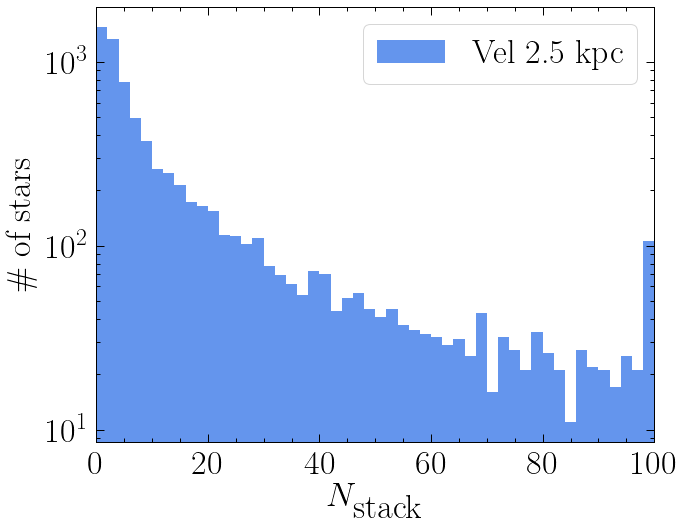

<Figure size 432x288 with 0 Axes>

In [165]:
# Count the appearance rate of these stars
count_res = Counter(cluster_id_non_noise_all)
print(len(count_res))
if space == 'E_act':
    label_text = r'E+Act ' + str(int(cut)/1000) + ' kpc'
elif space == 'vel_cyl':
    label_text = r'Vel ' + str(int(cut)/1000) + ' kpc'

# Make a histogram of the count rate of all stars
f = plt.figure(figsize=[10,8])
plt.hist(list(count_res.values()),bins=range(0,102,2),label=label_text)
plt.xlabel(r'$N_{\textrm{stack}}$')
plt.ylabel(r'\# of stars')
plt.yscale('log')
plt.xlim([0,100])
plt.legend()
plt.show()
plt.tight_layout()
f.savefig(plot_dir+'stacked_star_in_cluster_rate_dist.pdf')

In [166]:
list(count_res.keys())[0:10], list(count_res.values())[0:10]

([634469512611911168,
  1229243593148358016,
  1277708416434956288,
  2036711704106665856,
  2798457105022823296,
  2831494371421184512,
  2910503176753011840,
  3454083549225619712,
  5154102081099625344,
  5365473158505801088],
 [79, 3, 40, 5, 100, 100, 100, 72, 98, 100])

In [167]:
# Search for these stars in the entire sample for later plotting
# Technically speaking, I saved these stars index in my sample as well, but those are not unique and subject to change if I alter my sample
# To be safe, search with the source_id
cm_vel_all['N_in_clust'] = 0

# Slower search but safe
# count_res = Counter(cluster_id_non_noise_all)
# for i in range(len(count_res)):
#     stacked_star_index = np.where(cm_vel_all['source_id'] == list(count_res.keys())[i])[0][0]
#     cm_vel_all.loc[stacked_star_index,'N_in_clust'] = list(count_res.values())[i]

# Faster work around but sample dependent
count_res = Counter(cluster_ind_non_noise_all)
for i in range(len(count_res)):
    stacked_star_index = list(count_res.keys())[i]
    cm_vel_all.loc[stacked_star_index,'N_in_clust'] = list(count_res.values())[i]

In [168]:
# Quick check to make sure the faster workaround is consistent
count_res_tmp = Counter(cluster_id_non_noise_all)
list(count_res_tmp.keys())[0:5], list(count_res_tmp.values())[0:5],list(count_res.keys())[0:5], list(count_res.values())[0:5], cm_vel_all.loc[list(count_res.keys())[0:5],'source_id']

([634469512611911168,
  1229243593148358016,
  1277708416434956288,
  2036711704106665856,
  2798457105022823296],
 [79, 3, 40, 5, 100],
 [501582, 723098, 733101, 1379565, 1895863],
 [79, 3, 40, 5, 100],
 501582      634469512611911168
 723098     1229243593148358016
 733101     1277708416434956288
 1379565    2036711704106665856
 1895863    2798457105022823296
 Name: source_id, dtype: int64)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


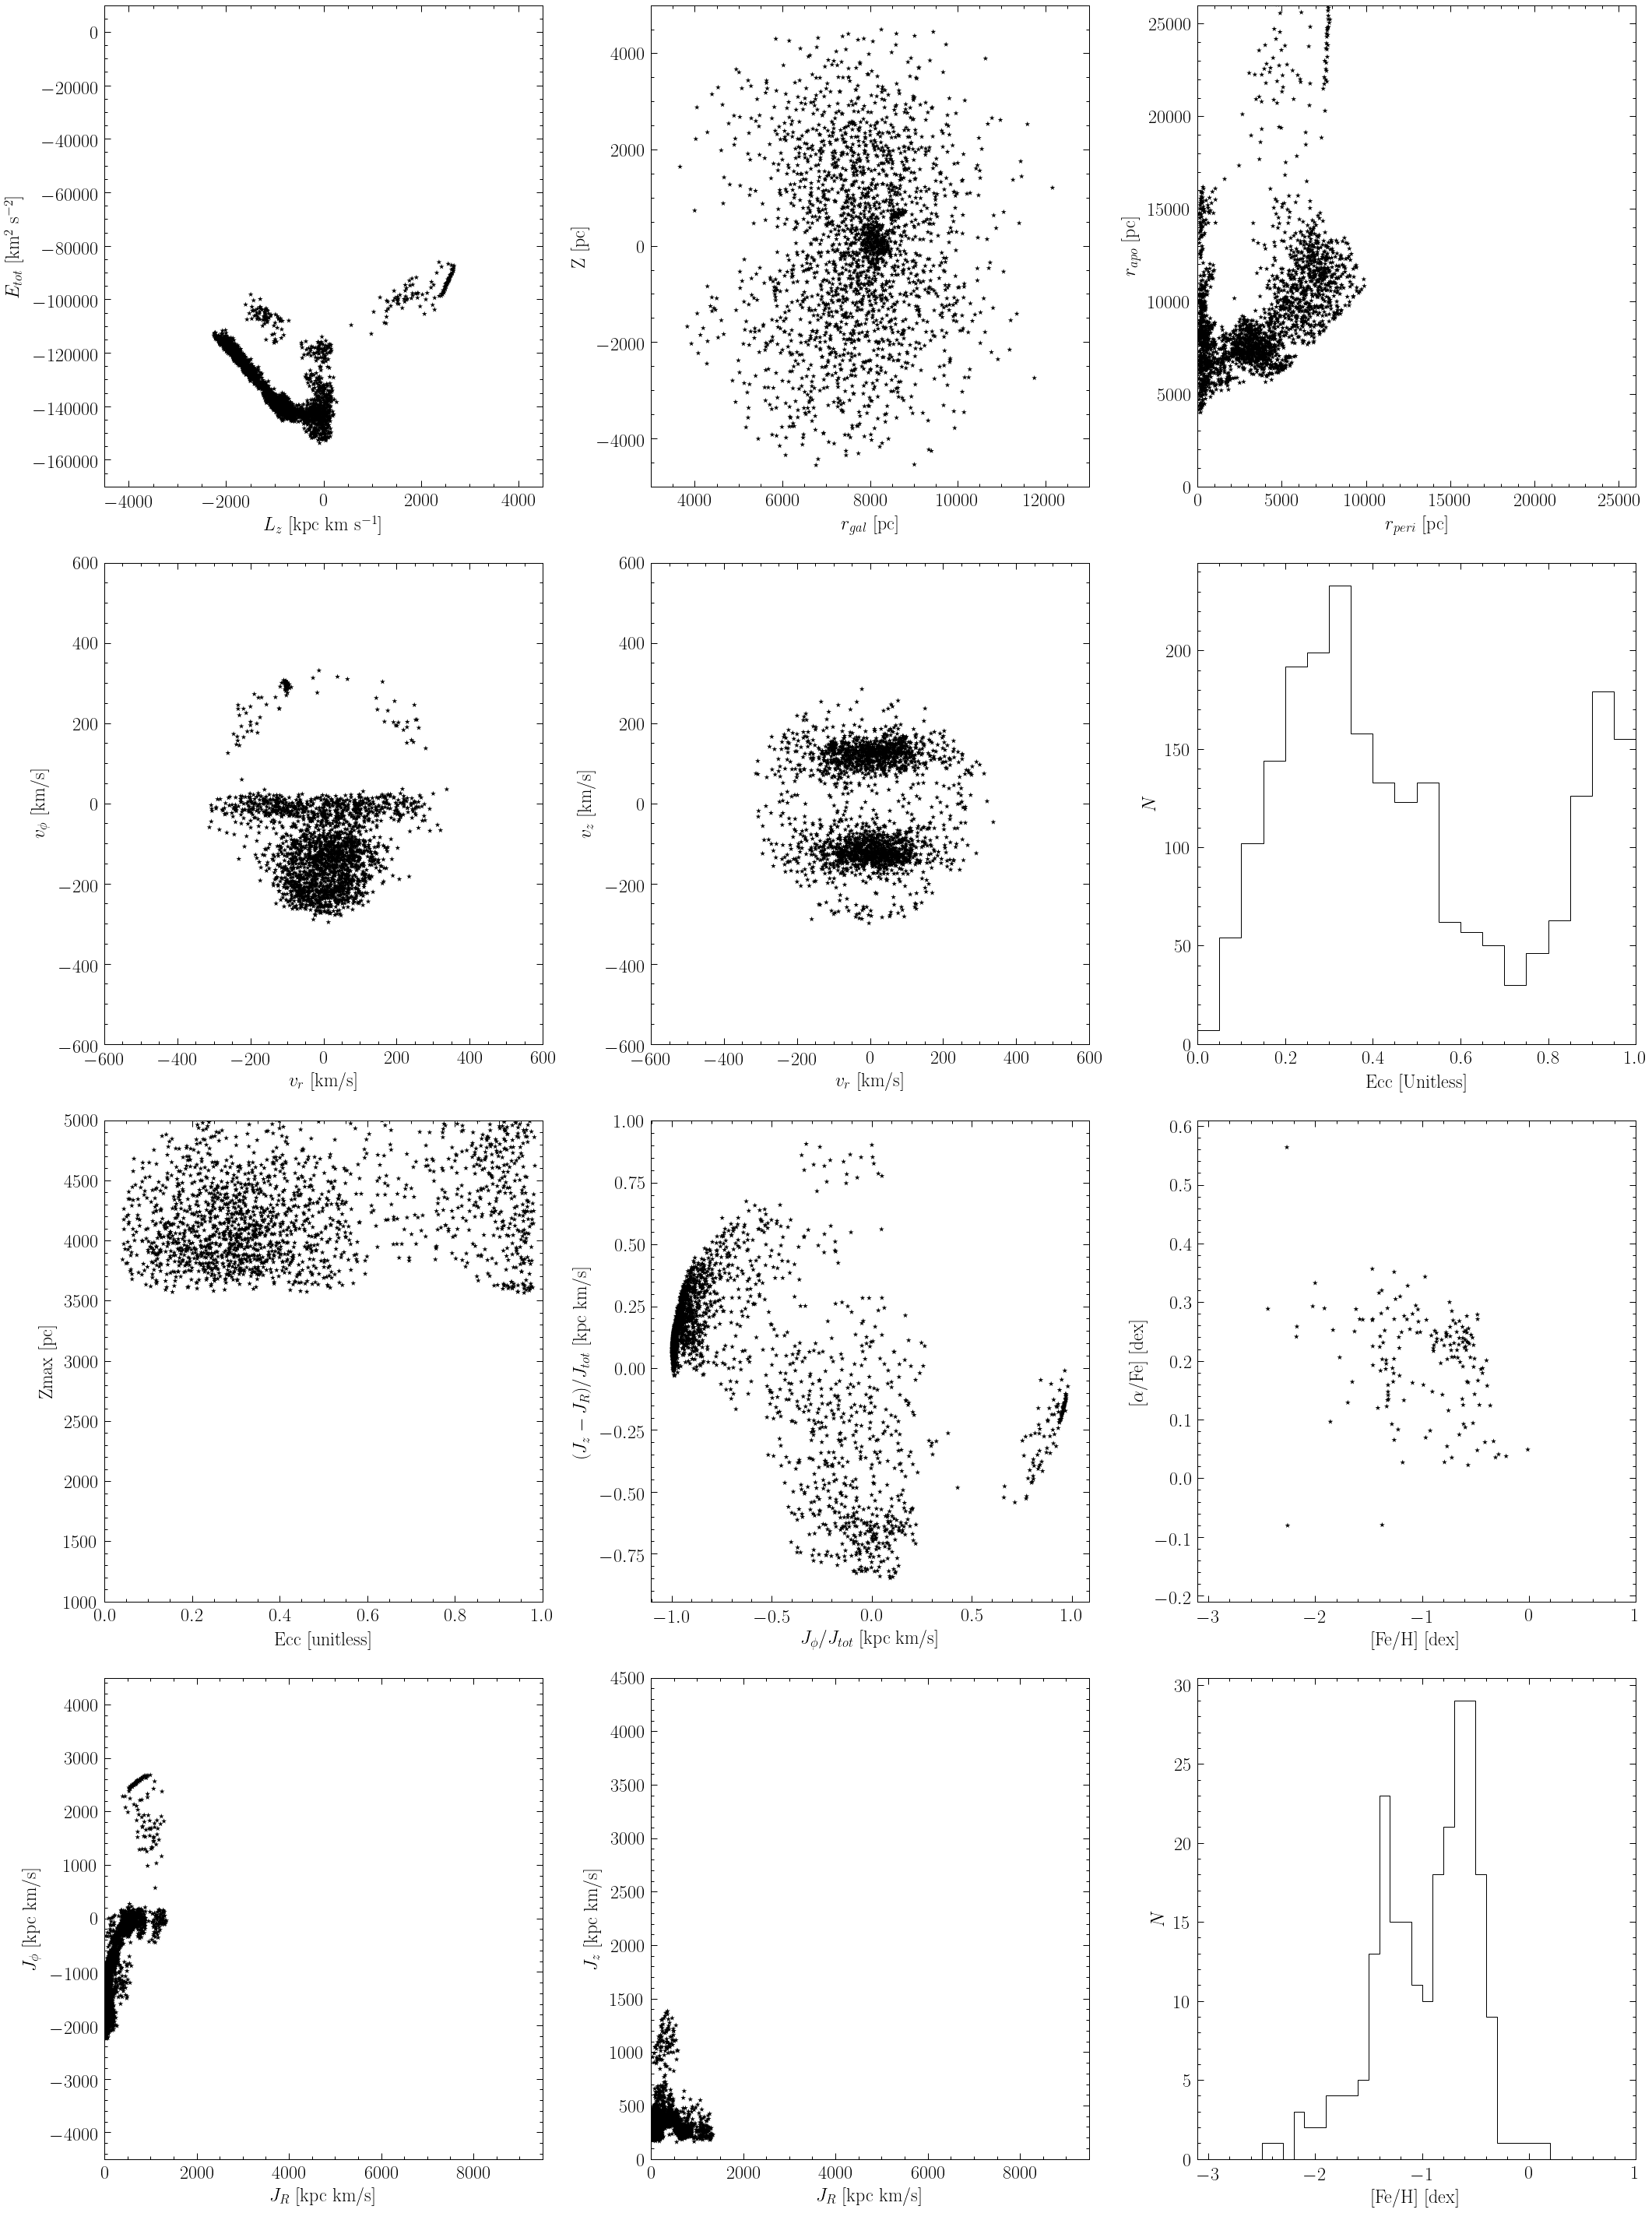

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


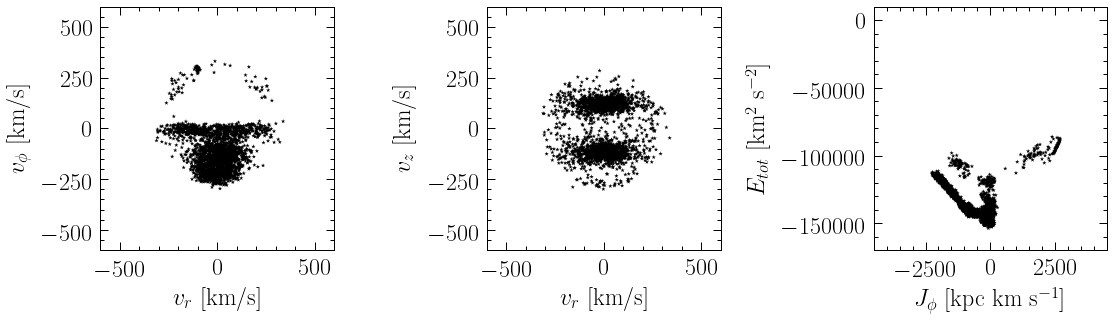

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


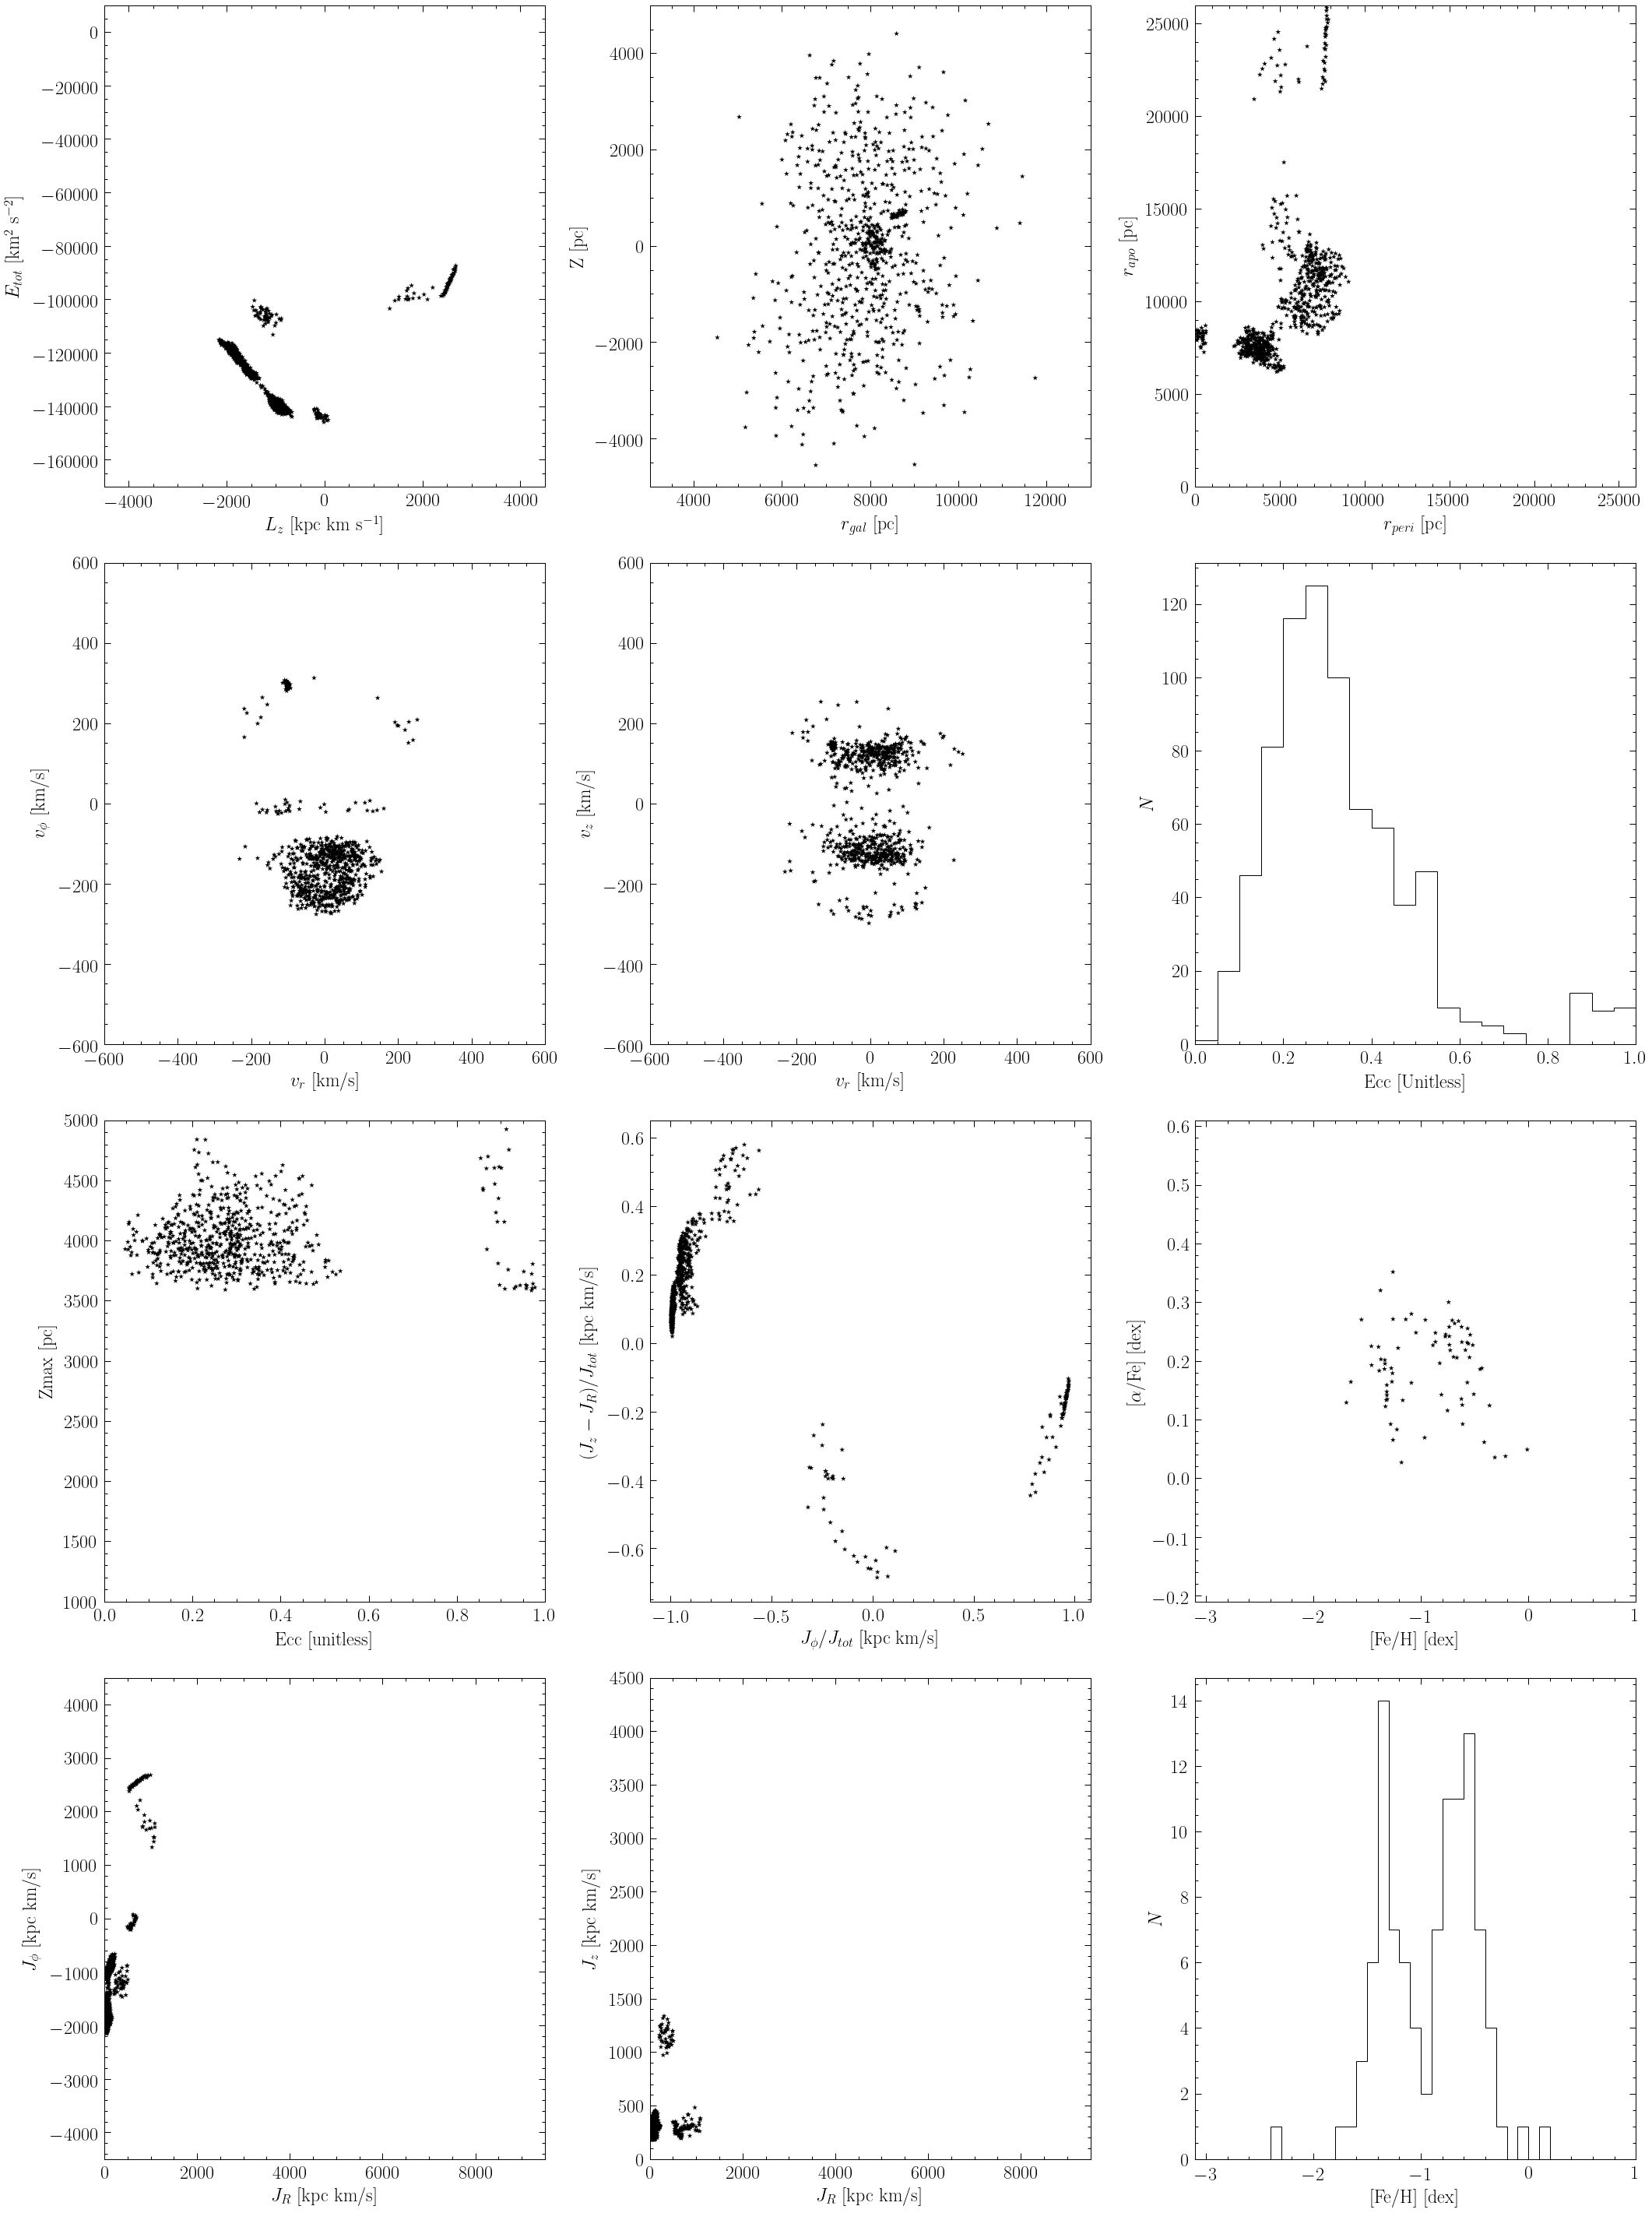

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


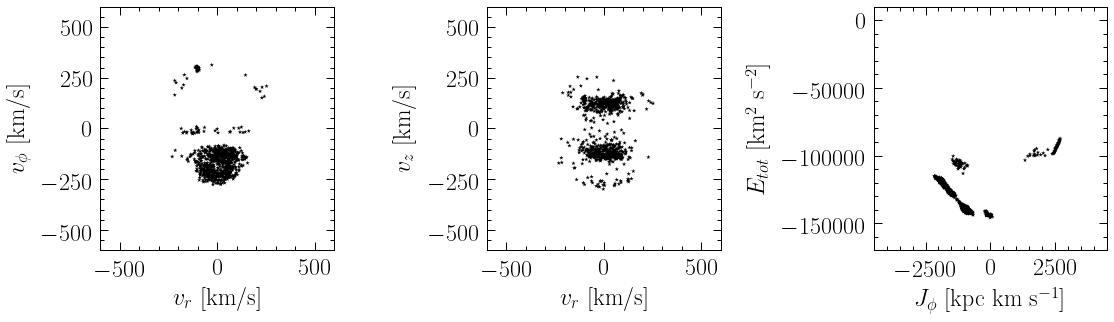

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


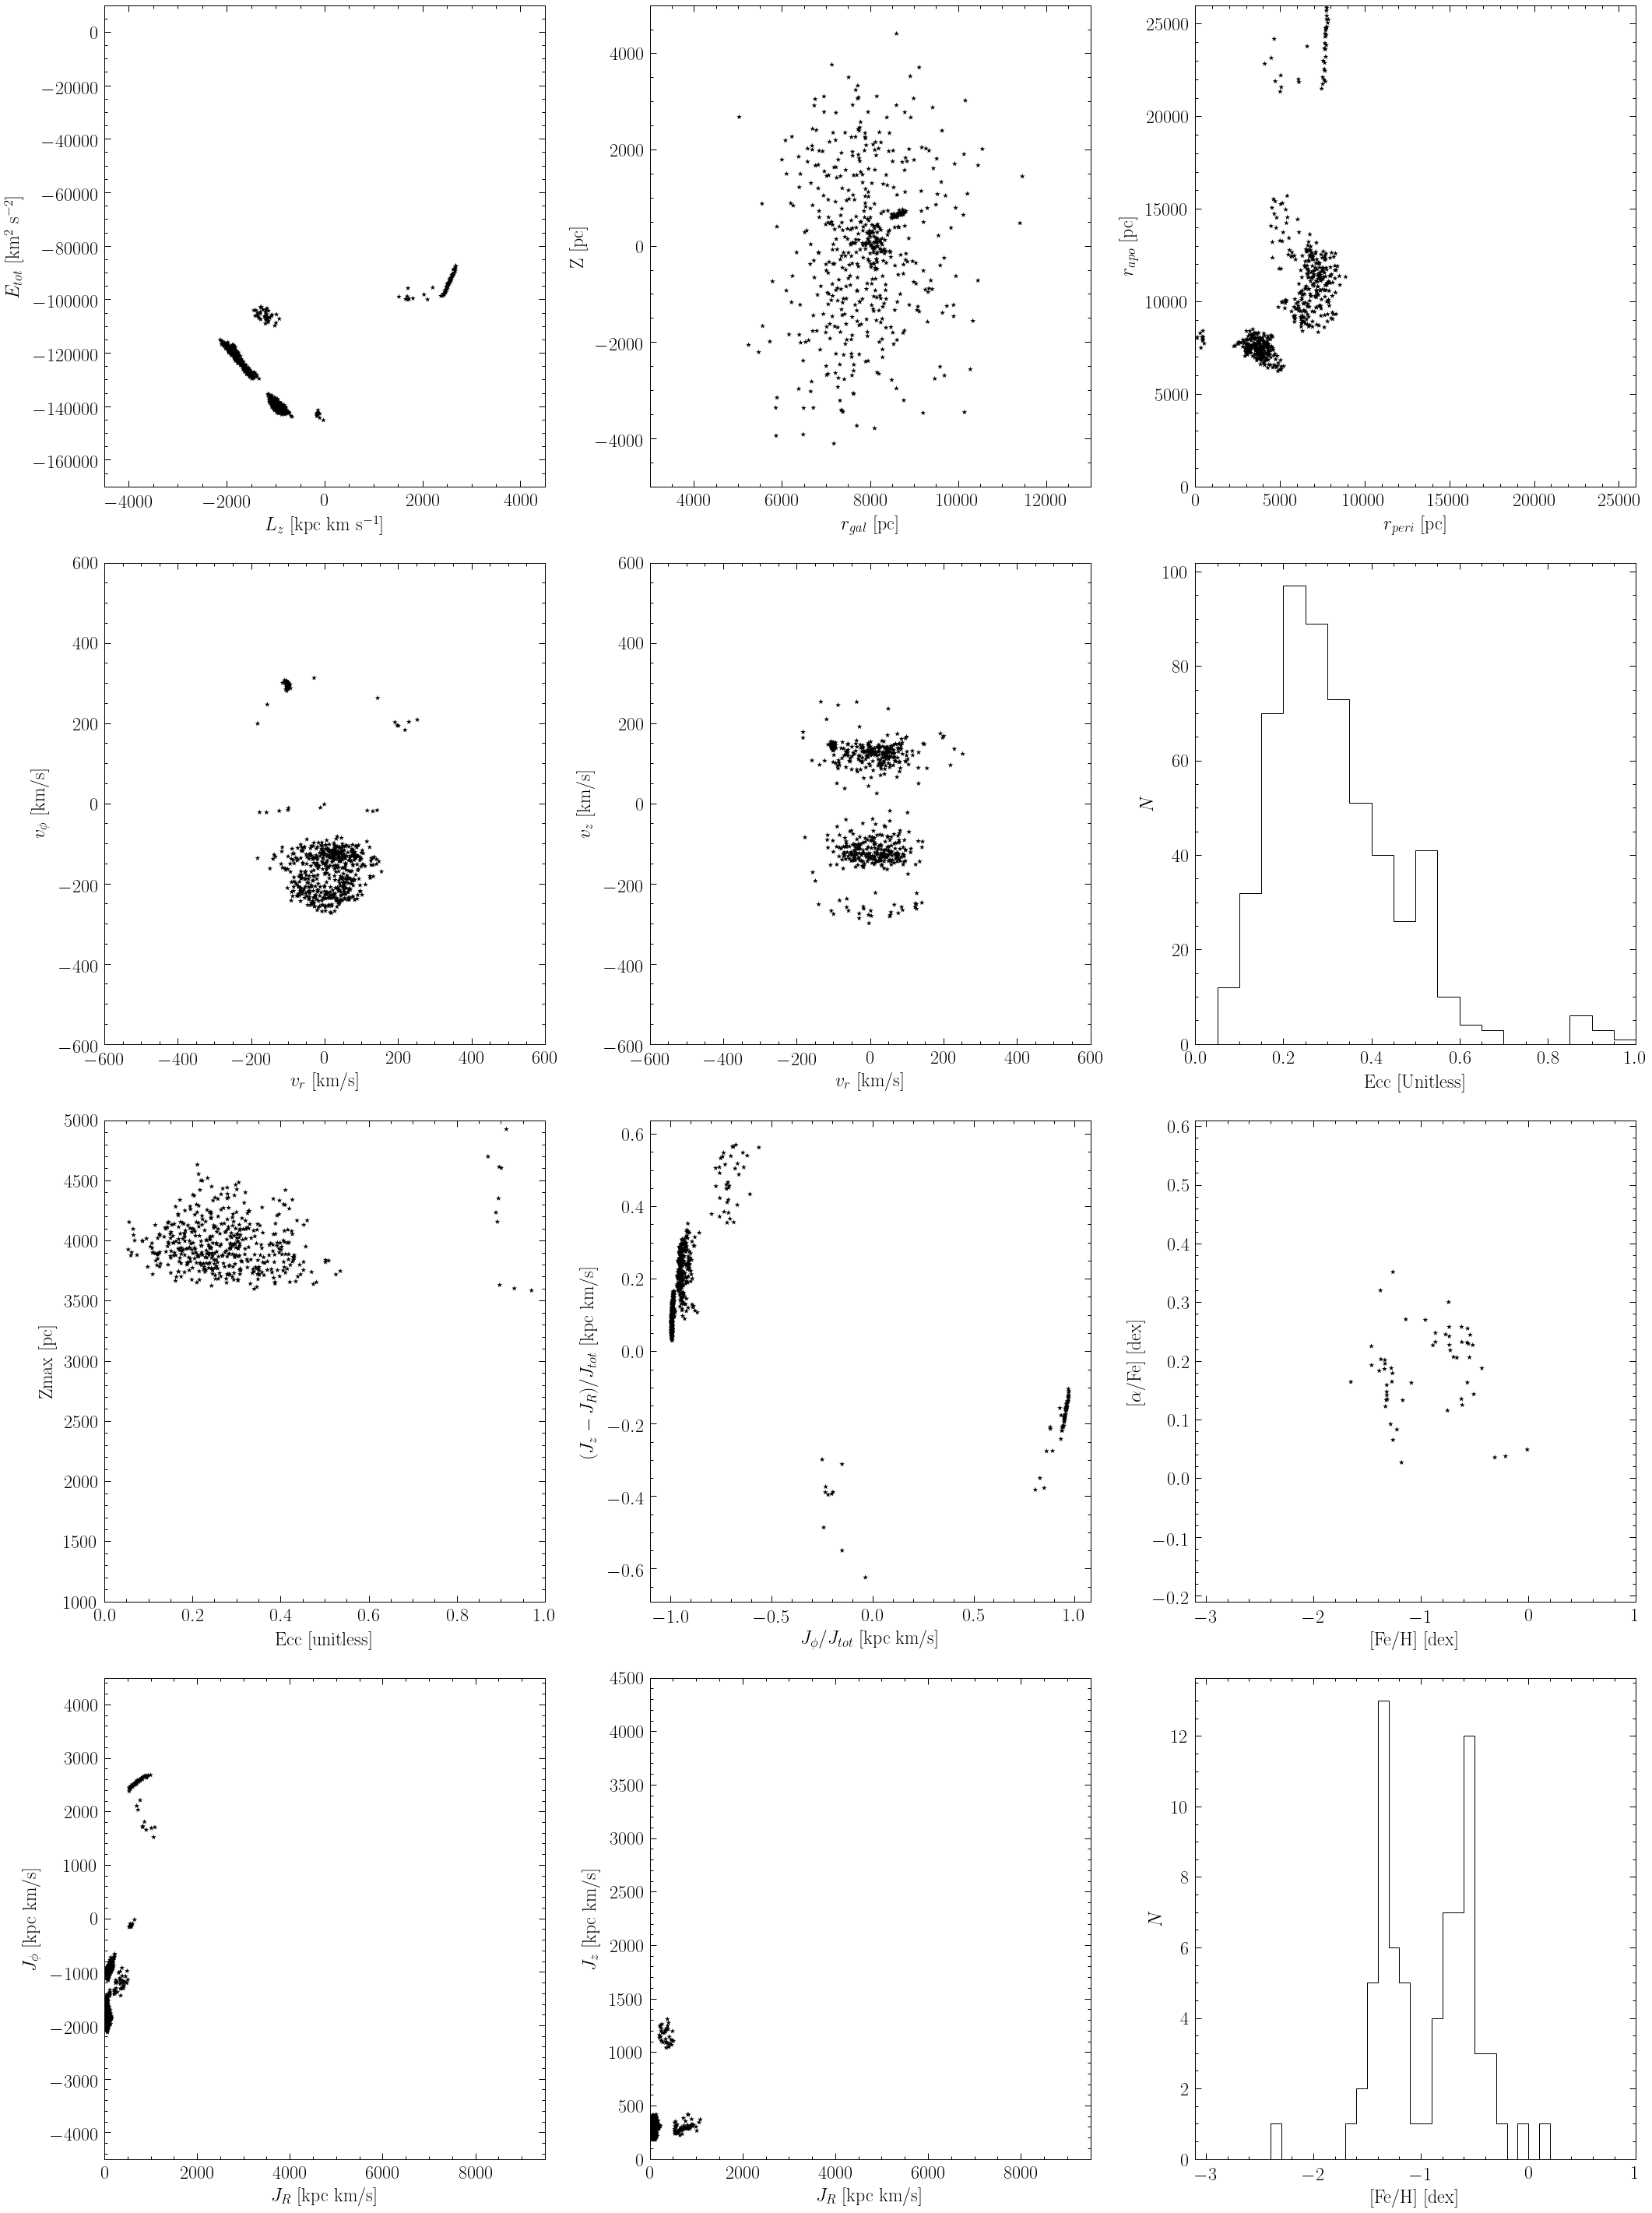

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


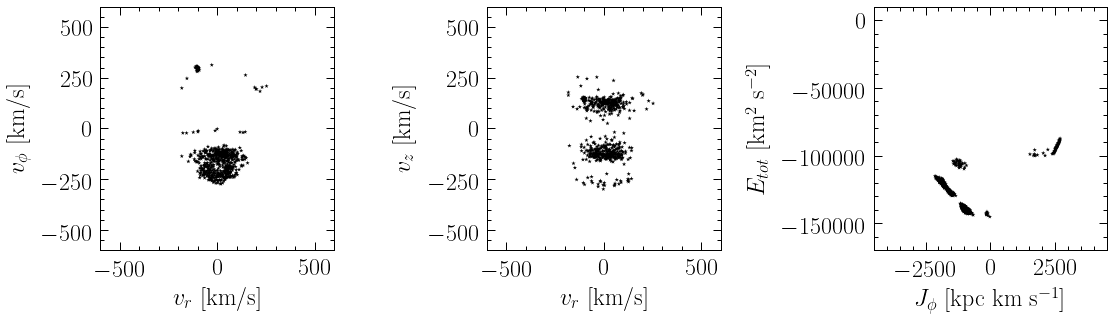

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


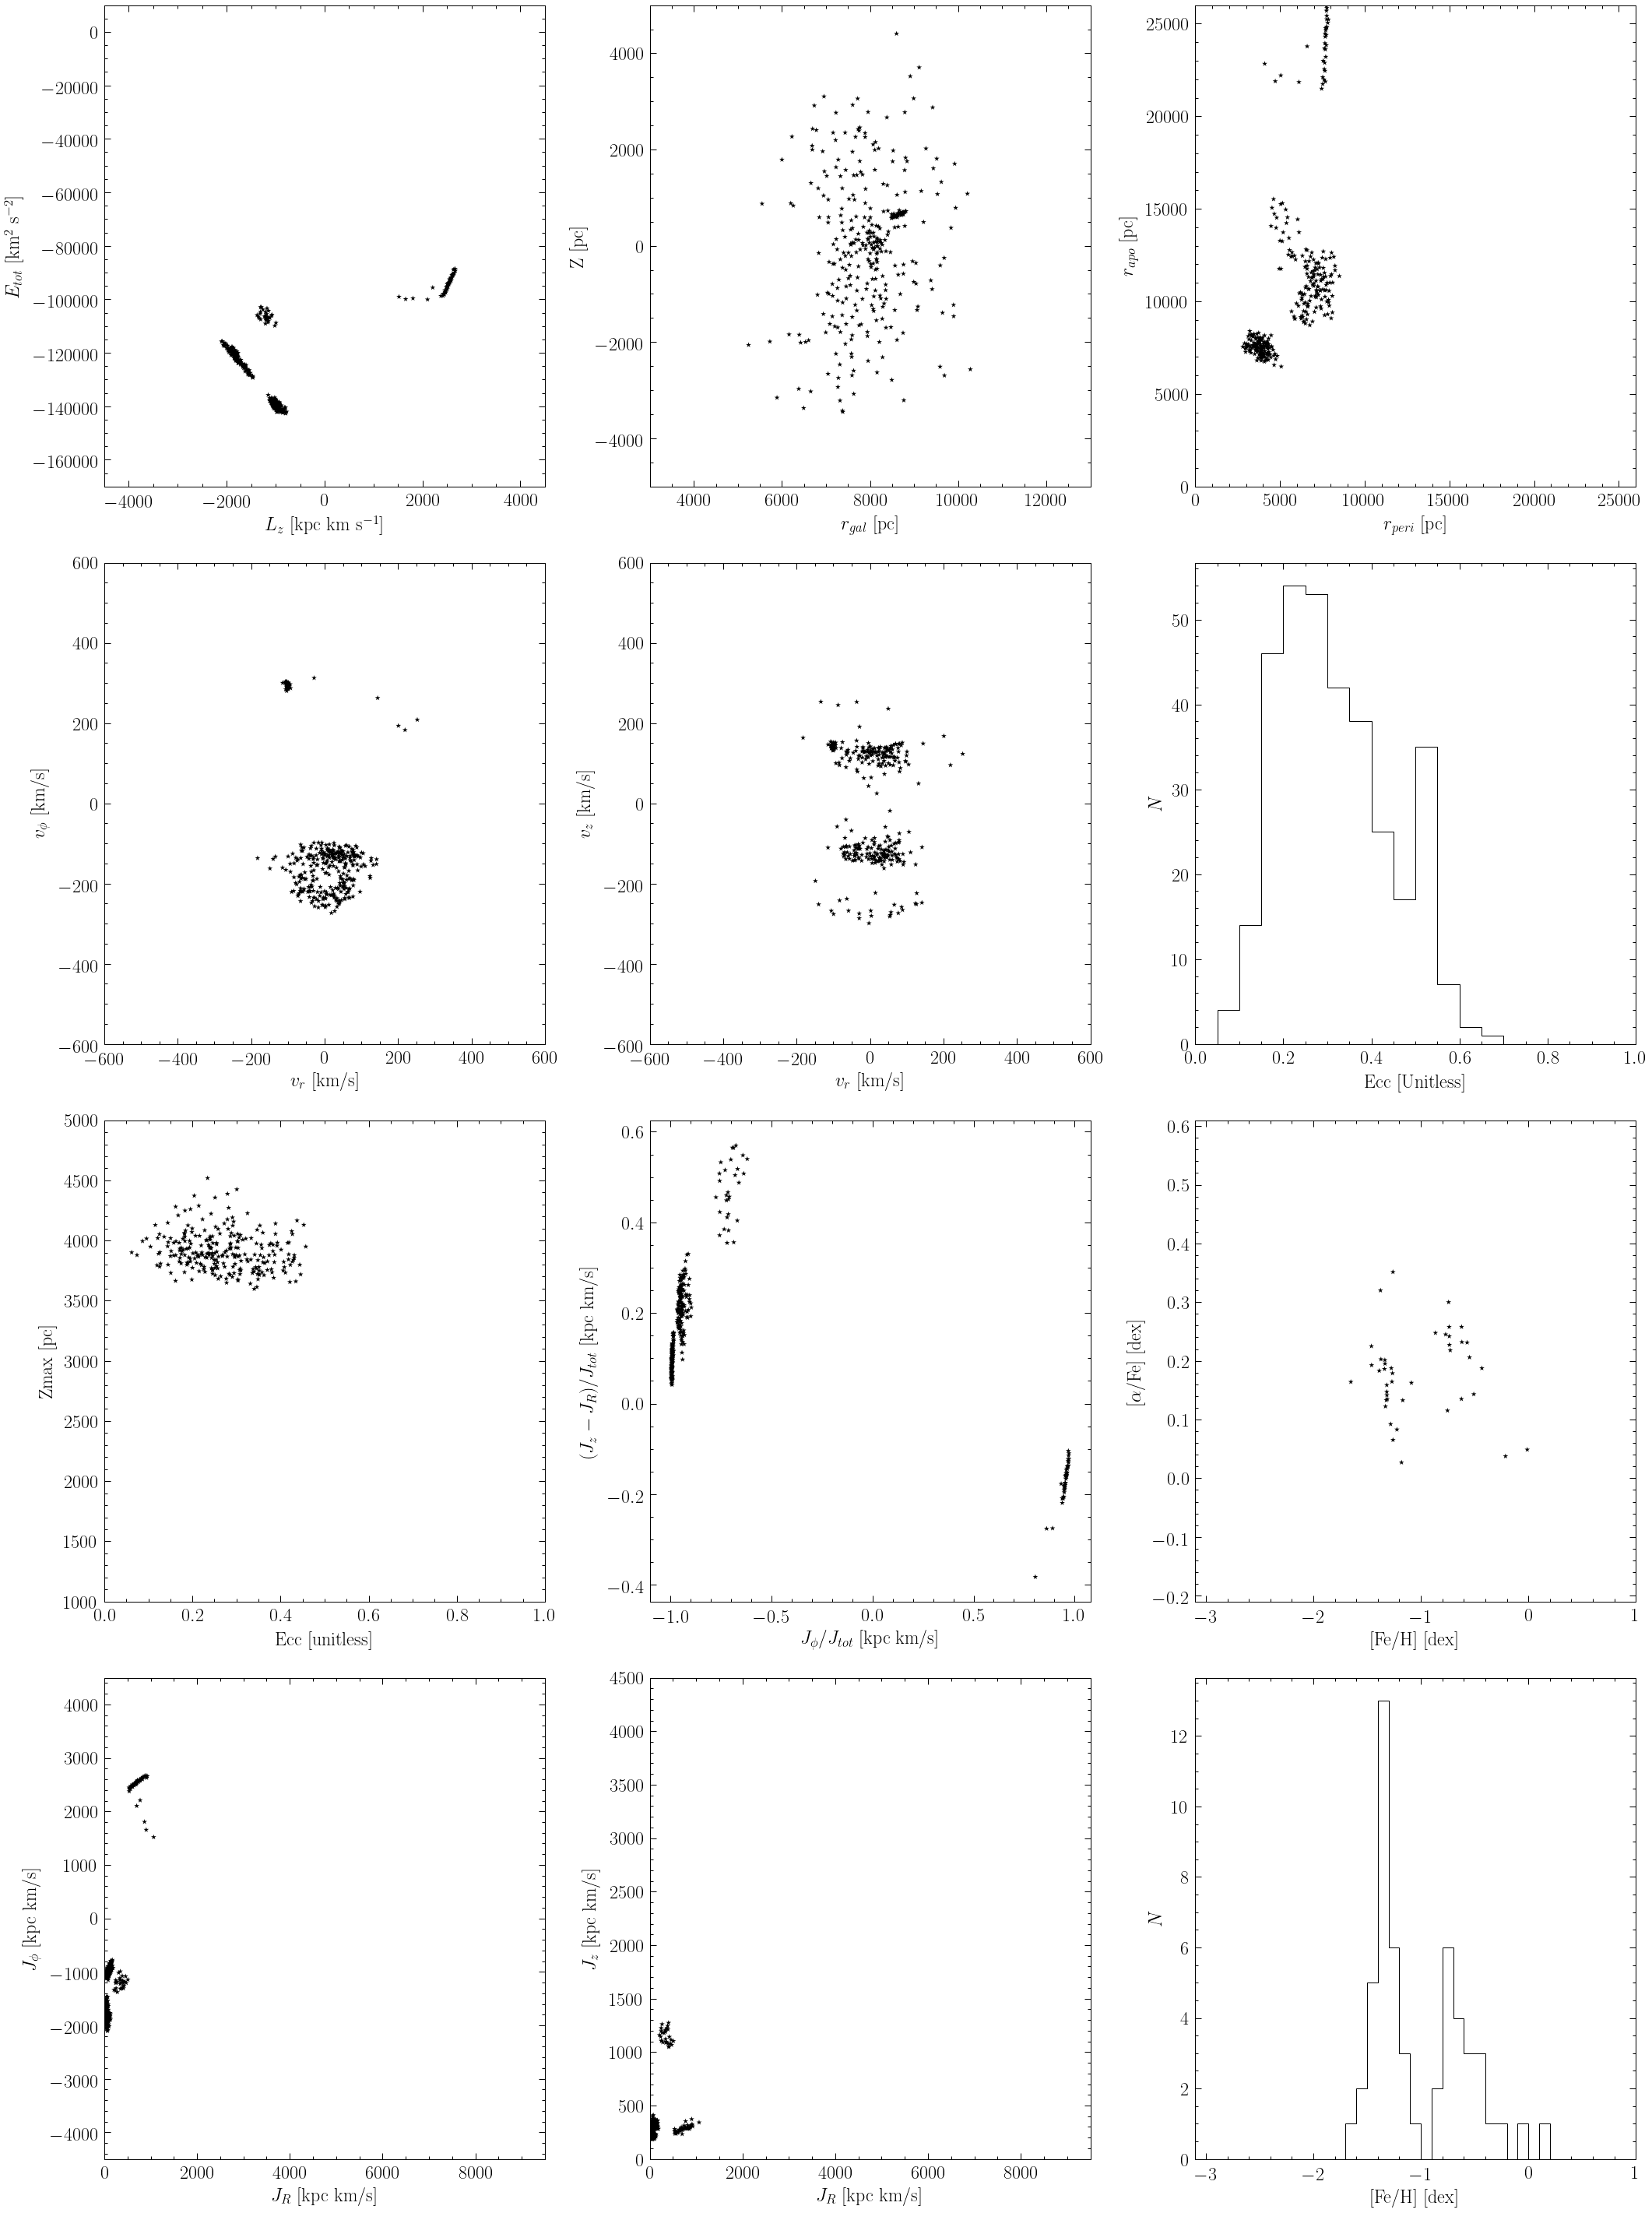

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


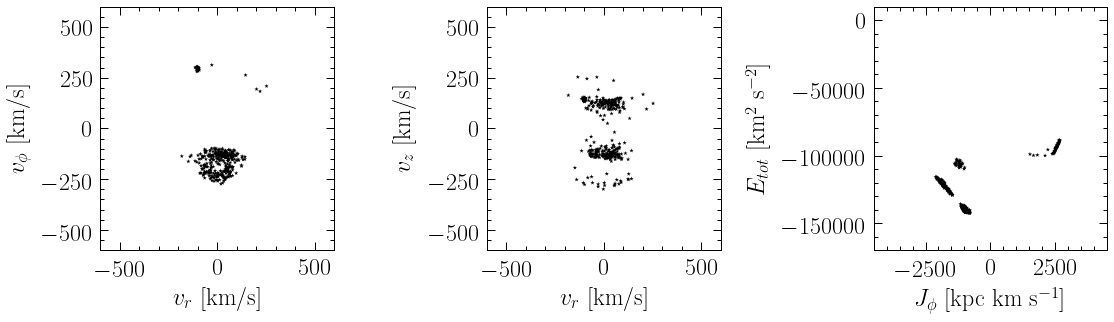

In [937]:
# Make summary plots and Error Distribution of the stars that appeared in some cluster vs. those appeared in >threshold times in some cluster

mask_in_clust = list(cm_vel_all['N_in_clust'] > 0)
stacked_dist_cut = [10,20,30]



# No cut
extratext = space + '_' + cut + '_stacked_stars_in_clust_summary'
# plot_summary_v3(cm_vel_all,orb_param_all,ind_list=[mask_in_clust],c_list=['k'],
#                 title='',legends=[''],list_mask=False,ind_add_cut=[],ds=False,
#                 filename=plot_dir+extratext+'_v3.pdf')

# plot_summary_short(cm_vel_all,orb_param_all,ind_list=[mask_in_clust],c_list=['k'],
#                 title='',legends=[''],list_mask=False,ind_add_cut=[],ds=False,
#                 filename=plot_dir+extratext+'_short.pdf')


# Apply the cut on the stacked distribution 
for i in range(len(stacked_dist_cut)):
    mask_in_clust_cut = list(cm_vel_all['N_in_clust'] > stacked_dist_cut[i])
    extratext = space + '_' + cut + '_stacked_stars_in_clust_summary_cut_' + str(stacked_dist_cut[i])
    plot_summary_v3(cm_vel_all,orb_param_all,ind_list=[mask_in_clust_cut],c_list=['k'],
                    title='',legends=[''],list_mask=False,ind_add_cut=[],ds=False,
                    filename=plot_dir+extratext+'_v3.pdf')
    
    plot_summary_short(cm_vel_all,orb_param_all,ind_list=[mask_in_clust_cut],c_list=['k'],
                    title='',legends=[''],list_mask=False,ind_add_cut=[],ds=False,
                    filename=plot_dir+extratext+'_short.pdf')

In [187]:
extratext

'_0420_g2only_err_no_cut_zmax_cut_2500_vel_cyl_hdbscan_min_samples_20_min_clustsize_20_leaf_samp_'

In [188]:
mask_bg.sum()

27921

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:162: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

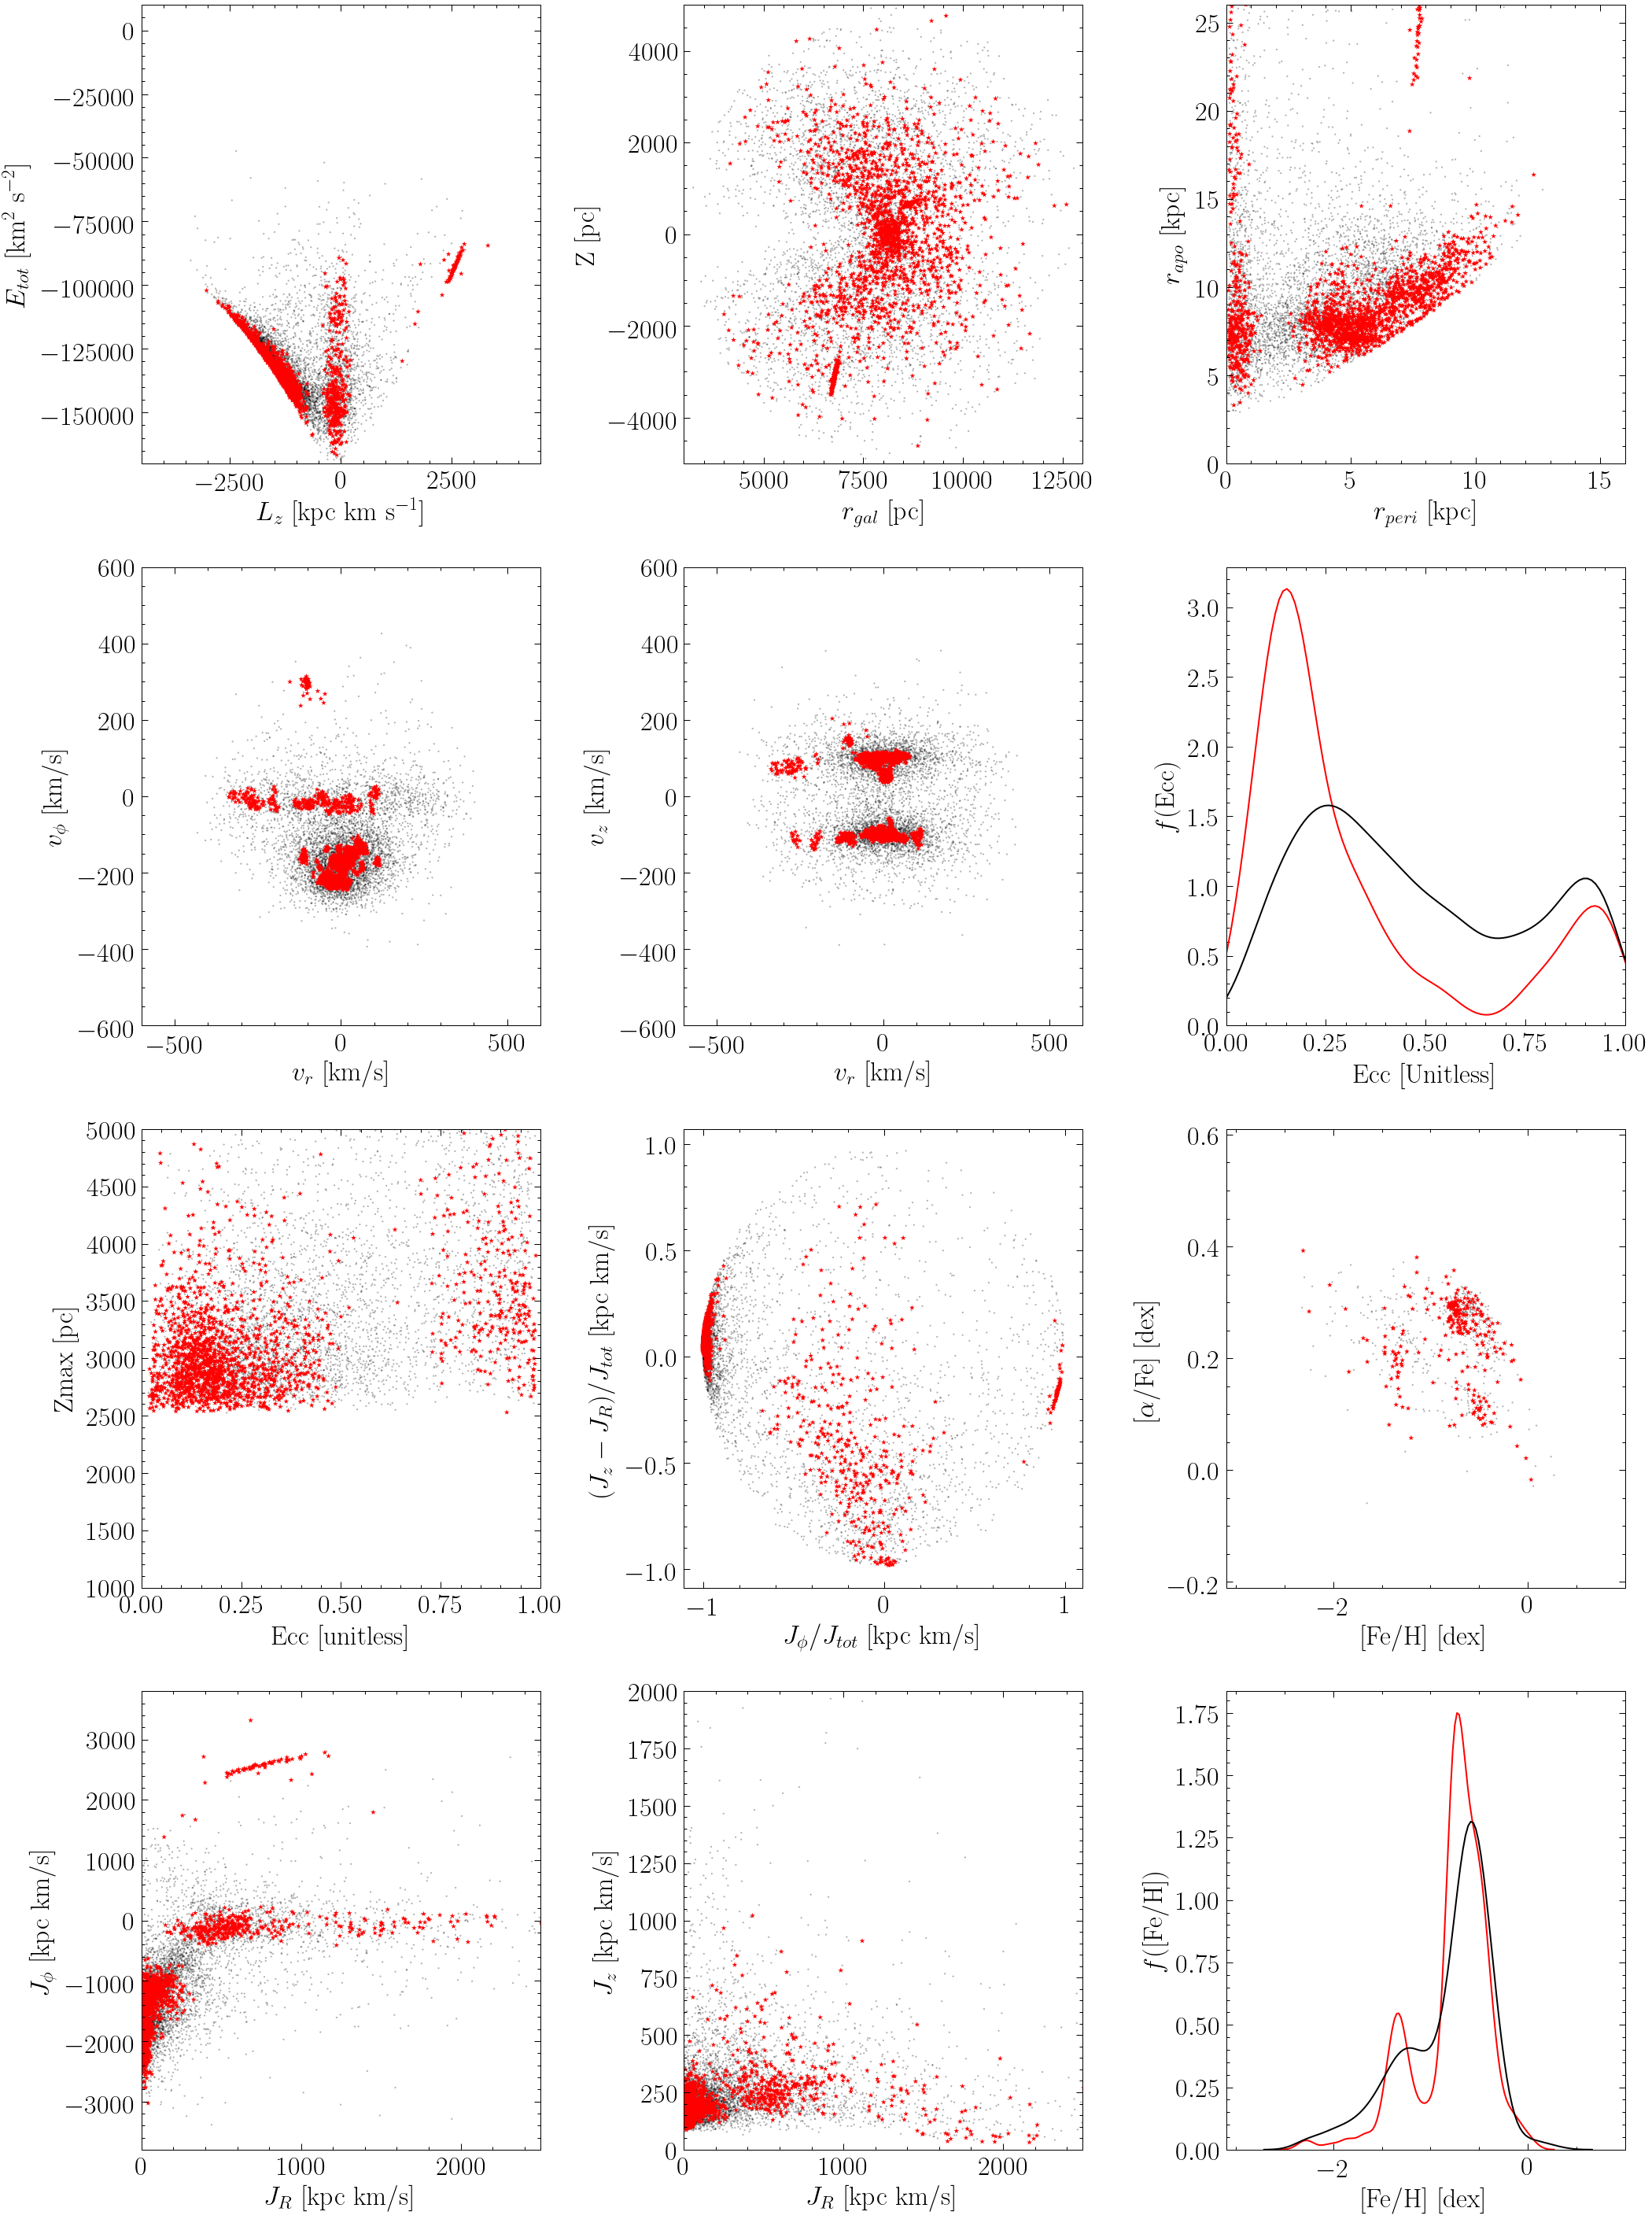

In [181]:
# Make summary plots showing the sample before and after Nstack cut at 20
# General kinematic quality cuts
kin_qual = ((abs(cm_vel_all['U_g2']) < 1000) & 
            (abs(cm_vel_all['V_g2']) < 1000) & (abs(cm_vel_all['W_g2']) < 1000) & 
            (cm_vel_all['qual_flag'] == 0) # & 
           )
selection = ((orb_param_all['zmax']-2*orb_param_all['e_zmax']) > int(cut))
mask_bg = kin_qual & selection

mask_in_clust_cut = list(cm_vel_all['N_in_clust'] > 20)

plot_summary_v3_kde(cm_vel_all,orb_param_all,ind_list=[mask_in_clust_cut,mask_bg],c_list=['r','k'],
                title='',legends=['',''],list_mask=True,ind_add_cut=np.arange(len(mask_in_clust_cut)),ds=True,noise=True,
                filename=plot_dir+'summary_0420_g2only_err_no_cut_zmax_cut_2500_vel_cyl_inclust_cut_20_bg_ds_v3.pdf')

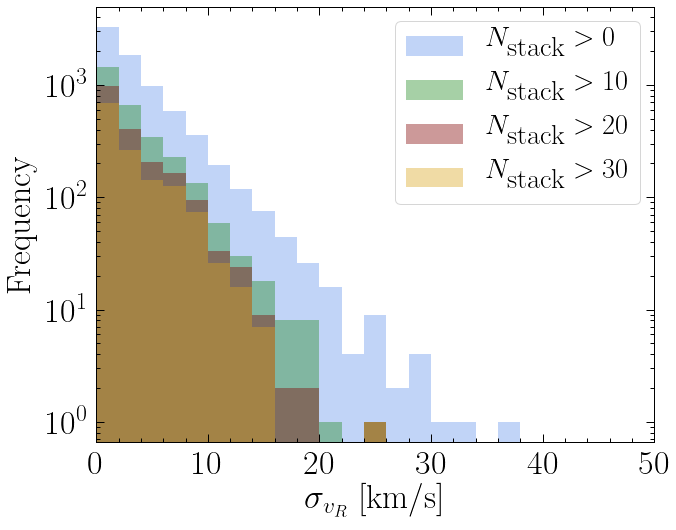

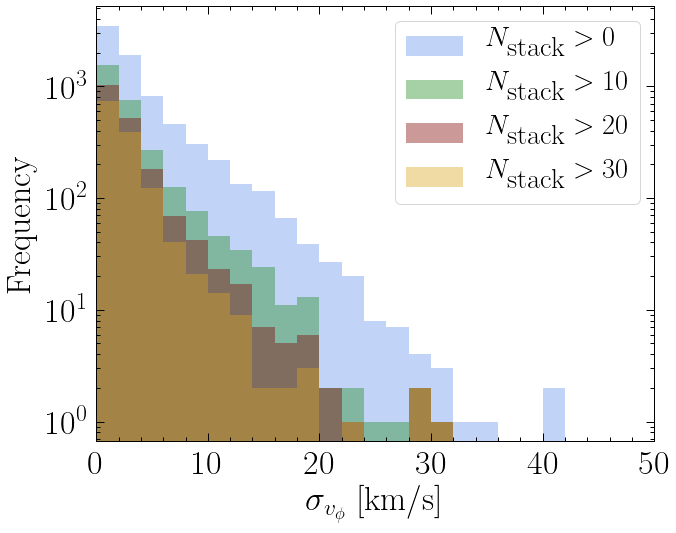

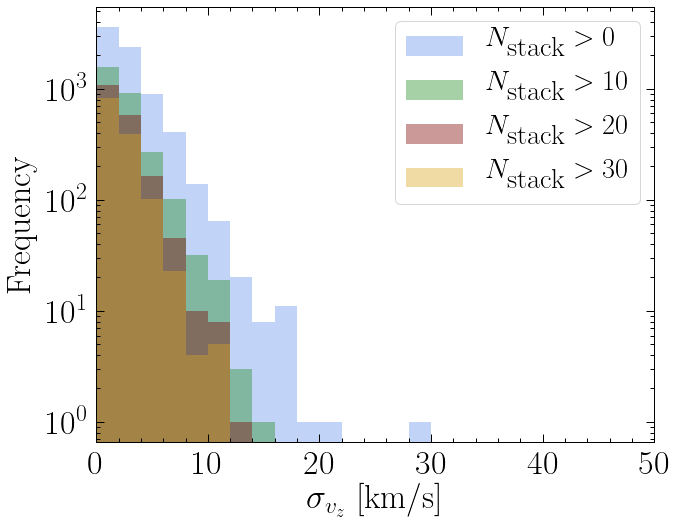

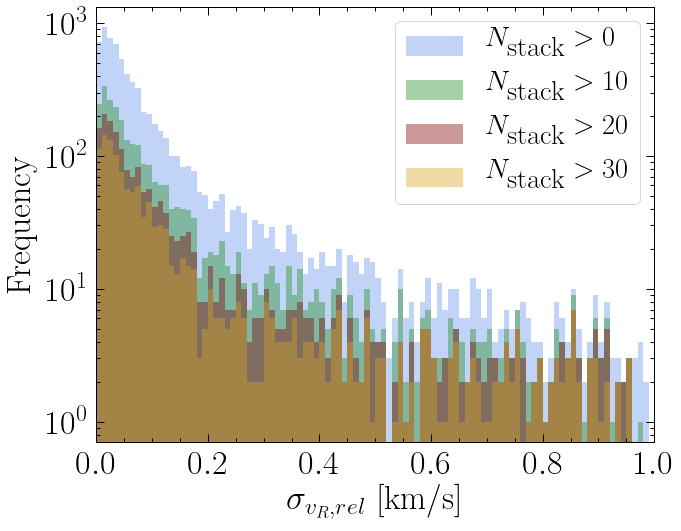

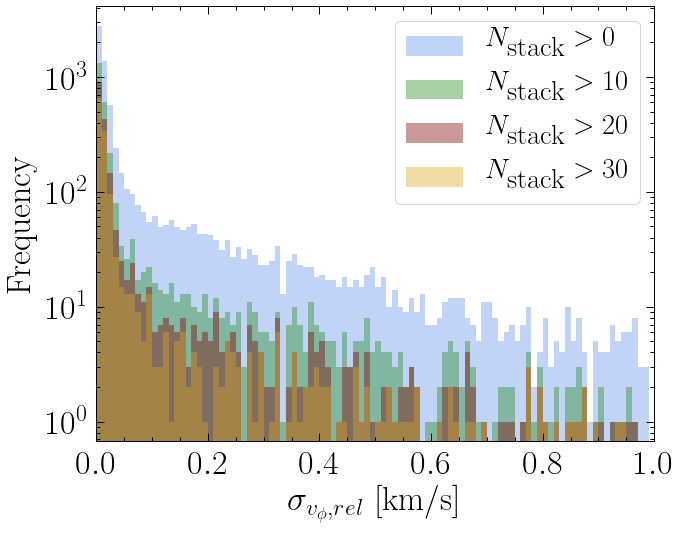

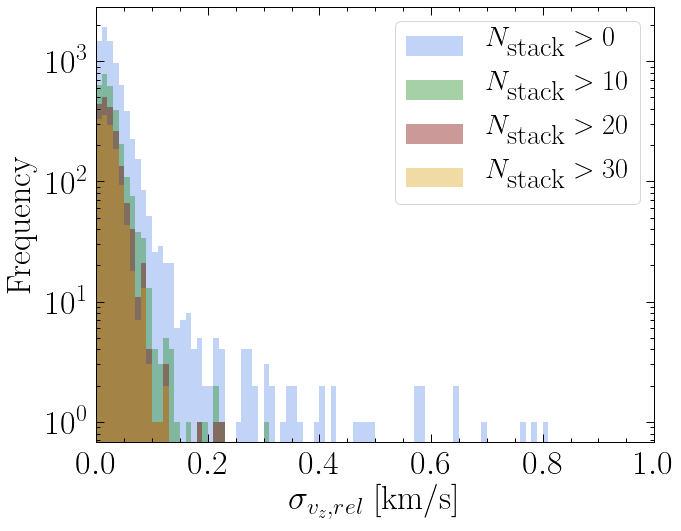

In [186]:
mask_in_clust = list(cm_vel_all['N_in_clust'] > 0)
stacked_dist_cut = [10,20,30]

if space == 'E_act':
    col_to_plot = ['e_Etot','e_JR','e_Jphi','e_Jz']
    rel_col_to_plot = ['Etot','JR','Jphi','Jz']
    axis_labels = [r'$\sigma_{E_{tot}}$',r'$\sigma_{J_{R}}$',r'$\sigma_{J_{\phi}}$',r'$\sigma_{J_{z}}$']
    xrange_list = [[0,10000],[0,500],[0,250],[0,250]]
    xbins_list = [np.arange(0,10000,100),np.arange(0,500,5),np.arange(0,250,2.5),np.arange(0,250,2.5)]
    
        
    # Plot the absolute error distribution
    for col, axis_label, xrange, xbins in zip(col_to_plot,axis_labels,xrange_list,xbins_list):
        # Compute the data
        data_to_plot = [orb_param_all.loc[mask_in_clust,col]]
        label_to_plot = ['In cluster']
        for i in range(len(stacked_dist_cut)):
            mask_in_clust_cut = list(cm_vel_all['N_in_clust'] > stacked_dist_cut[i])
            data_to_plot.append(orb_param_all.loc[mask_in_clust_cut,col])
            label_to_plot.append(r'In more than '+str(stacked_dist_cut[i])+' cluster')
        
        plot_dist(data_list=data_to_plot,
                  label_list=label_to_plot,xlabel=axis_label,xrange=xrange,ylog=True,
                  hist=True,kde=False,bins=xbins,fname=plot_dir+col+'_' + cut + '_stacked_stars_low_in_clust_err_dist.pdf')
    
    # Plot the relative error distribution
    axis_labels = [r'$\sigma_{E_{tot},rel}$',r'$\sigma_{J_{R},rel}$',r'$\sigma_{J_{\phi},rel}$',r'$\sigma_{J_{z},rel}$']
    for col, rel_col, axis_label in zip(col_to_plot,rel_col_to_plot,axis_labels):
        # Compute data
        label_to_plot = ['In cluster']
        rel_data_to_plot = [abs(orb_param_all.loc[mask_in_clust,col]/orb_param_all.loc[mask_in_clust,rel_col])]
        for i in range(len(stacked_dist_cut)):
            mask_in_clust_cut = list(cm_vel_all['N_in_clust'] > stacked_dist_cut[i])
            label_to_plot.append(r'In more than '+str(stacked_dist_cut[i])+' cluster')
            rel_data_to_plot.append(abs(orb_param_all.loc[mask_in_clust_cut,col]/orb_param_all.loc[mask_in_clust_cut,rel_col]))
        
        plot_dist(data_list=rel_data_to_plot,
                  label_list=label_to_plot,xlabel=axis_label,xrange=[0,1],ylog=True,
                  hist=True,kde=False,bins=np.arange(0,1,0.01),fname=plot_dir+col+'_' + cut + '_stacked_stars_low_in_clust_rel_err_dist.pdf')
        
elif space == 'vel_cyl':
    col_to_plot = ['vrerr_g2','vphierr_g2', 'vzerr_g2']
    rel_col_to_plot = ['vr_g2','vphi_g2', 'vz_g2']
    axis_labels = [r'$\sigma_{v_{R}}$ [km/s]',r'$\sigma_{v_{\phi}}$ [km/s]',r'$\sigma_{v_{z}}$ [km/s]']
    
    
    # Plot the absolute error distribution
    for col, axis_label in zip(col_to_plot,axis_labels):
        data_to_plot = [cm_vel_all.loc[mask_in_clust,col]]
        label_to_plot = [r'$N_{\textrm{stack}}>0$']
        for i in range(len(stacked_dist_cut)):
            mask_in_clust_cut = list(cm_vel_all['N_in_clust'] > stacked_dist_cut[i])
            data_to_plot.append(cm_vel_all.loc[mask_in_clust_cut,col])
            label_to_plot.append(r'$N_{\textrm{stack}}>'+str(stacked_dist_cut[i])+'$')
        
        plot_dist(data_list=data_to_plot,
                  label_list=label_to_plot,xlabel=axis_label,xrange=[0,50],ylog=True,
                  hist=True,kde=False,bins=np.arange(0,52,2),fname=plot_dir+col+'_' + cut + '_stacked_stars_low_in_clust_err_dist.pdf')
    
    # Plot the relative error distribution
    axis_labels = [r'$\sigma_{v_{R},rel}$ [km/s]',r'$\sigma_{v_{\phi},rel}$ [km/s]',r'$\sigma_{v_{z},rel}$ [km/s]']
    for col, rel_col, axis_label in zip(col_to_plot,rel_col_to_plot,axis_labels):
        label_to_plot = [r'$N_{\textrm{stack}}>0$']
        rel_data_to_plot = [abs(cm_vel_all.loc[mask_in_clust,col]/cm_vel_all.loc[mask_in_clust,rel_col])]
        for i in range(len(stacked_dist_cut)):
            mask_in_clust_cut = list(cm_vel_all['N_in_clust'] > stacked_dist_cut[i])
            label_to_plot.append(r'$N_{\textrm{stack}}>'+str(stacked_dist_cut[i])+'$')
            rel_data_to_plot.append(abs(cm_vel_all.loc[mask_in_clust_cut,col]/cm_vel_all.loc[mask_in_clust_cut,rel_col]))
        
        plot_dist(data_list=rel_data_to_plot,
                  label_list=label_to_plot,xlabel=axis_label,xrange=[0,1],ylog=True,
                  hist=True,kde=False,bins=np.arange(0,1,0.01),fname=plot_dir+col+'_' + cut + '_stacked_stars_low_in_clust_rel_err_dist.pdf')

In [118]:
# Go through the different cuts one-by-one
stacked_dist_cut = [10,20,30]
index_stacked_dist_cut = 1
ind_cut = np.where(cm_vel_all['N_in_clust'] > stacked_dist_cut[index_stacked_dist_cut])[0]
extratext = '_' + space + '_' + cut + '_stacked_stars_in_clust_cut_' + str(stacked_dist_cut[index_stacked_dist_cut]) + '_hdbscan'
# ind_cut = np.where(cm_vel_all['N_in_clust'] > 0)[0]
# extratext = '_' + space + '_' + cut + '_stacked_stars_in_clust_hdbscan'
print(len(ind_cut))
# Cut the dataframe
df_cut_vel = cm_vel_all.loc[ind_cut,:]
df_cut_orb = orb_param_all.loc[ind_cut,:]

1097


In [119]:
# Define the clustering parameters
min_samples = 20
min_cluster_size = 20
cluster_selection_method = 'leaf'
extratext += '_min_samples_'+str(min_samples)
extratext += '_min_clustsize_'+str(min_cluster_size)
extratext += '_'+str(cluster_selection_method)

In [120]:
# Pick out the stacked stars and apply HDBscan to them 
# The scaling will be different 
# Add in the dimensions as needed 
ydata_ini = []

if space == 'vel_cyl':
    ydata_ini.append(df_cut_vel["vr_g2"])
    ydata_ini.append(df_cut_vel["vphi_g2"])
    ydata_ini.append(df_cut_vel["vz_g2"])
elif space == 'E_act':
    ydata_ini.append(df_cut_orb['JR'])
    ydata_ini.append(df_cut_orb['Jphi'])
    ydata_ini.append(df_cut_orb['Jz'])
    ydata_ini.append(df_cut_orb['Etot'])

ydata = np.array(ydata_ini).T

X = RobustScaler().fit_transform(ydata)

In [121]:
n_clusters_estimated = 60
if space == 'vel_cyl':
    n_dim=3
elif space == 'E_act':
    n_dim=4


cluster_means = np.zeros((n_clusters_estimated, n_dim))
cluster_dispersions = np.zeros((n_clusters_estimated, n_dim))    
cluster_nstars = np.zeros((n_clusters_estimated))
print(n_dim)

cluster_spatial_positions = np.zeros((n_clusters_estimated, 3))
cluster_velocities = np.zeros((n_clusters_estimated, 3))

print(np.shape(X),np.shape(ydata),extratext)

3
(1097, 3) (1097, 3) _vel_cyl_3500_stacked_stars_in_clust_cut_20_hdbscan_min_samples_20_min_clustsize_20_leaf


Estimated number of clusters: 11
Estimated number stars in clusters: 799
Estimated number of noise points: 298
unique_labels are {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
k is 0
k is 1
k is 2
k is 3
k is 4
k is 5
k is 6
k is 7
k is 8
k is 9
k is 10
k is -1
Shape of member stars (12,)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

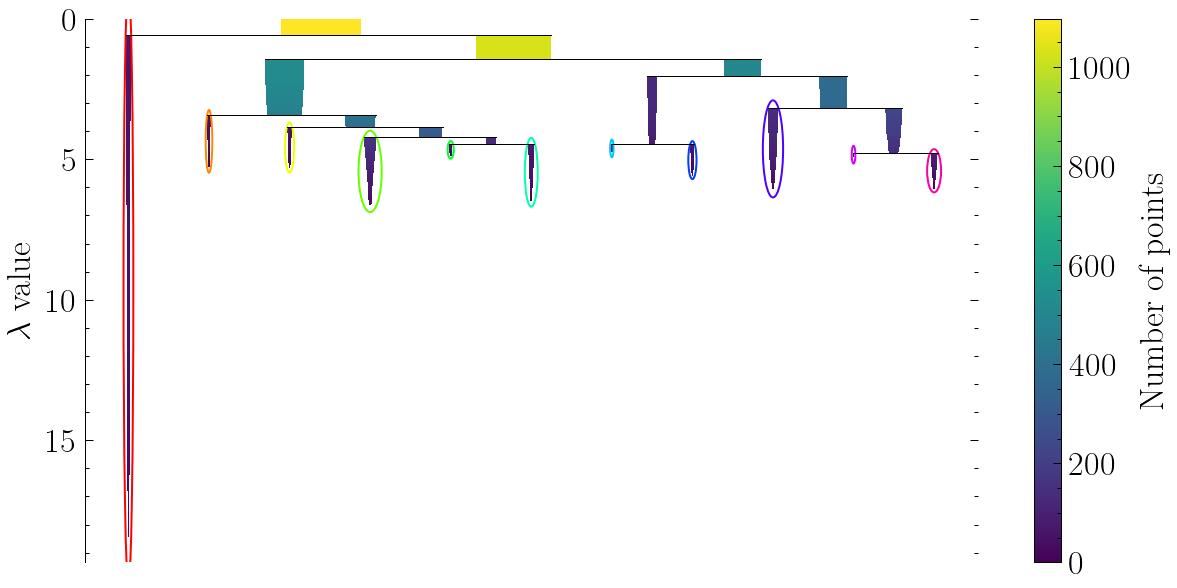

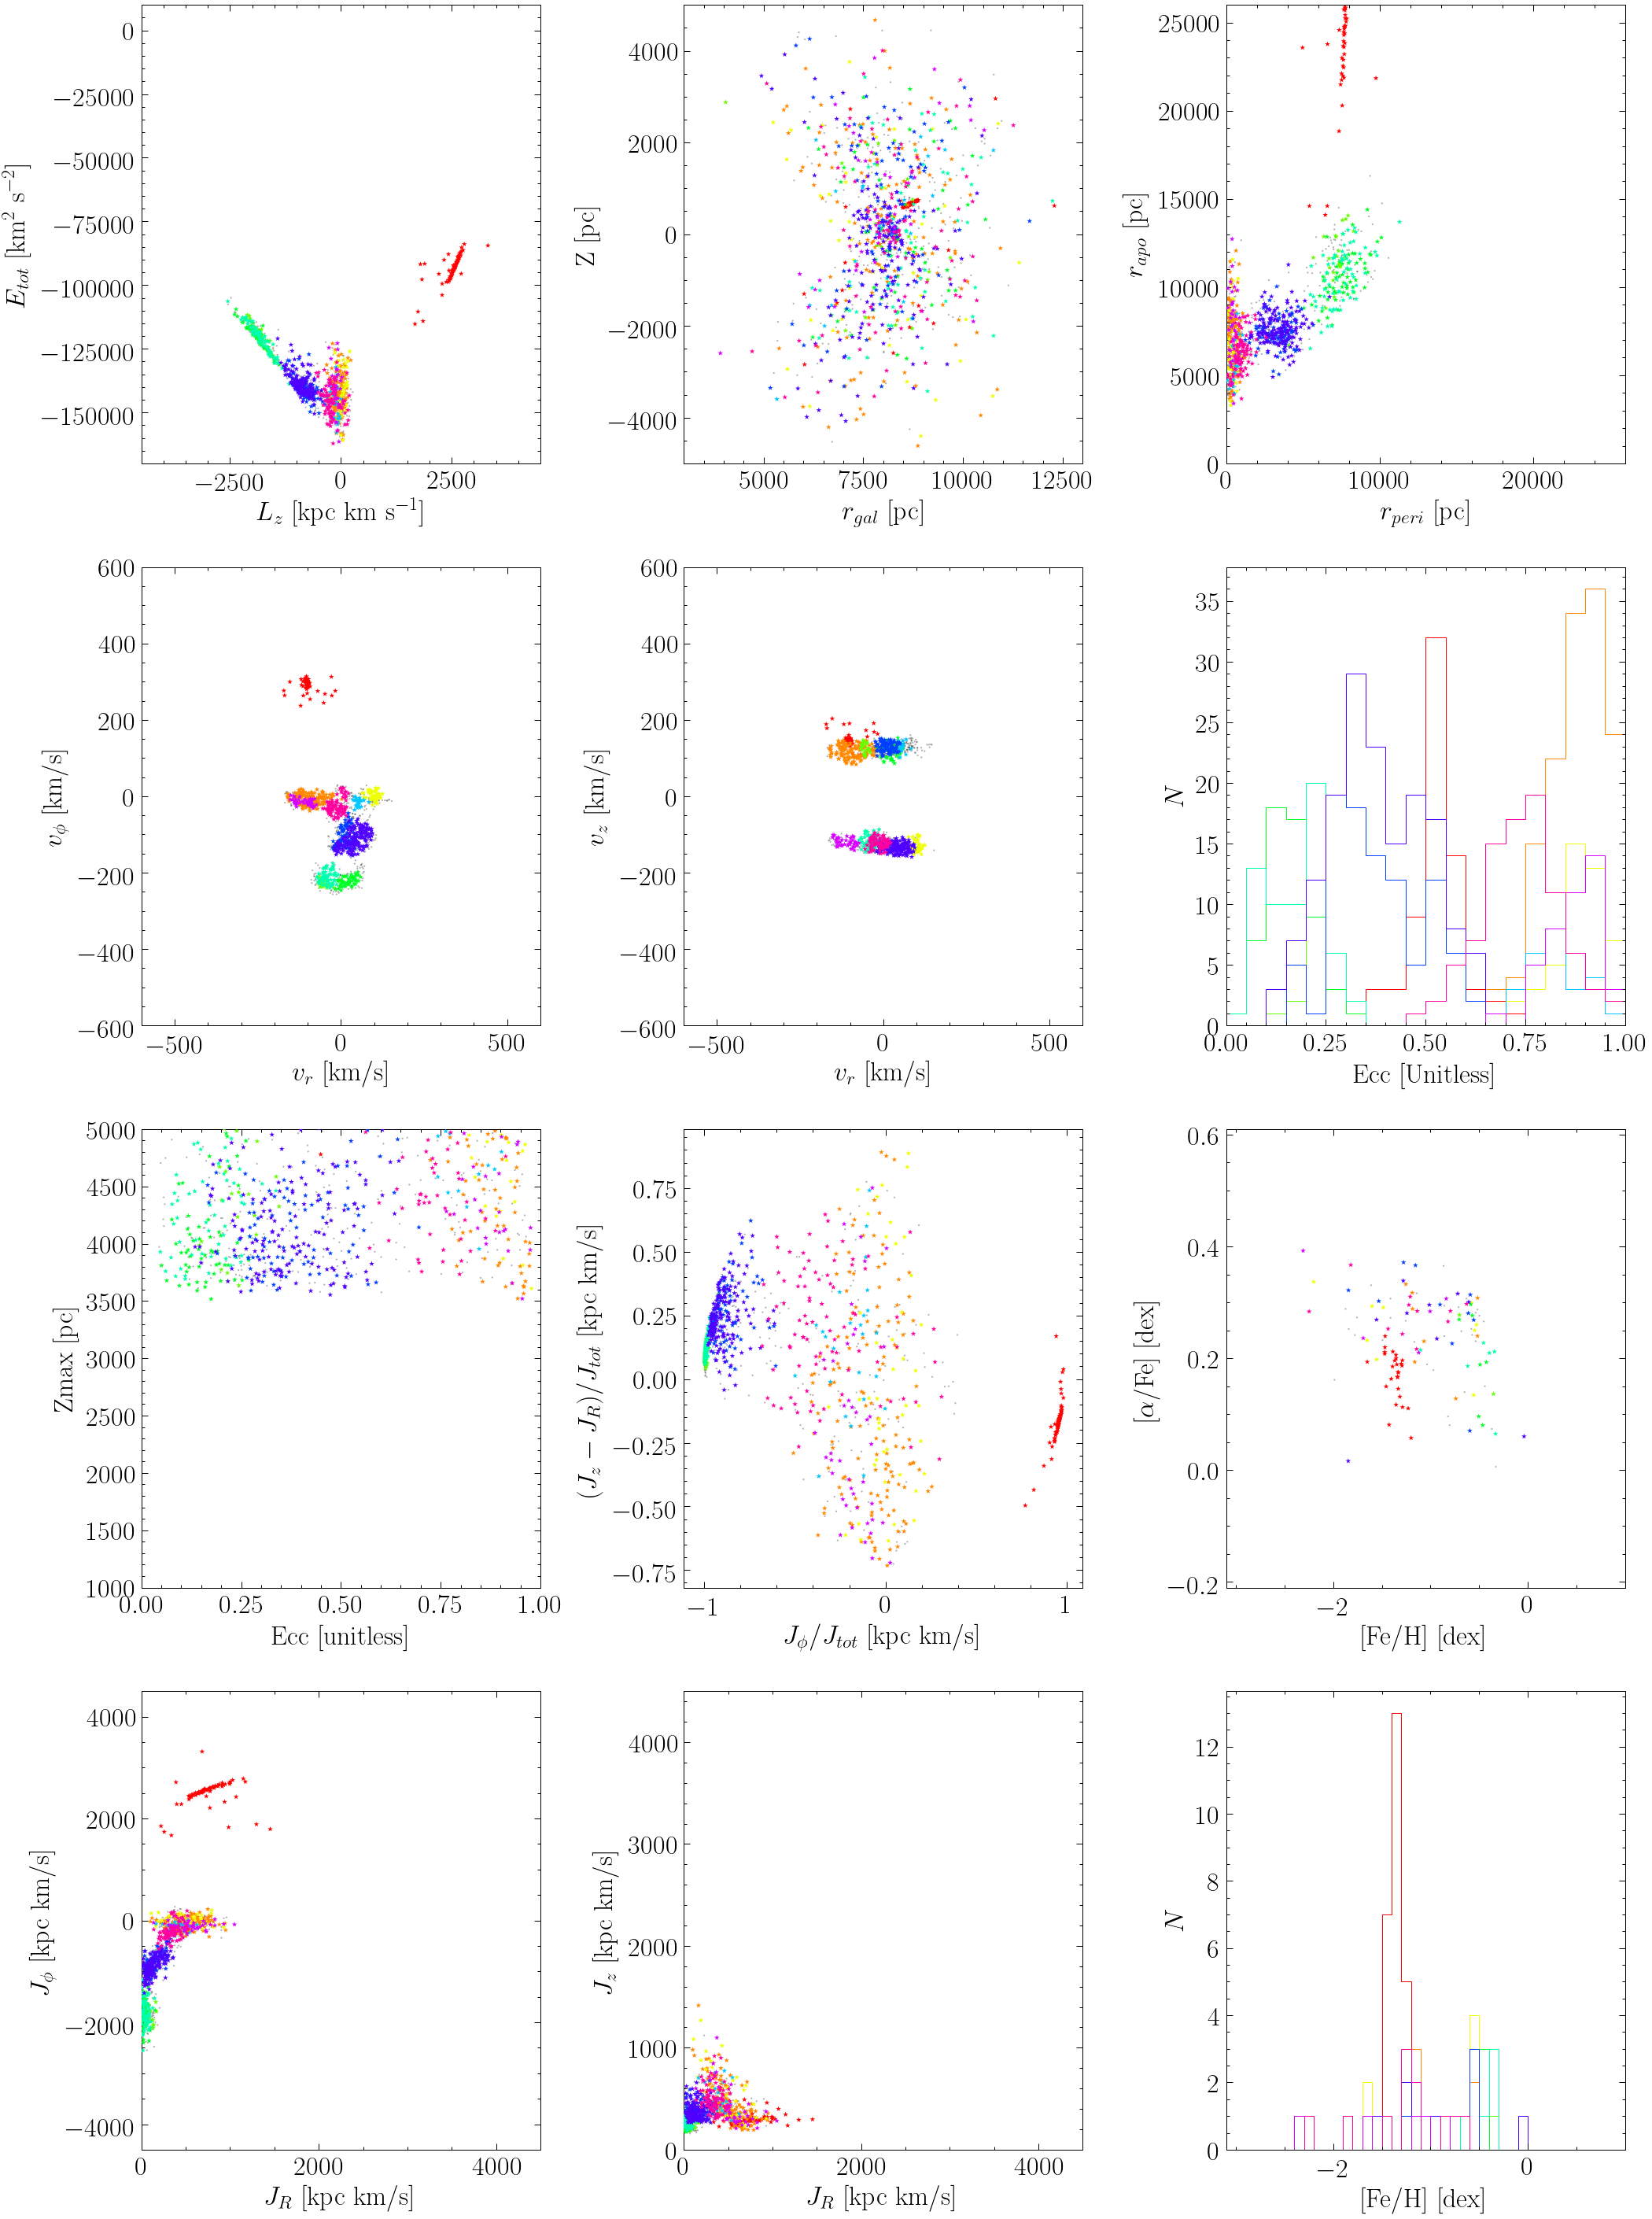

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:159: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

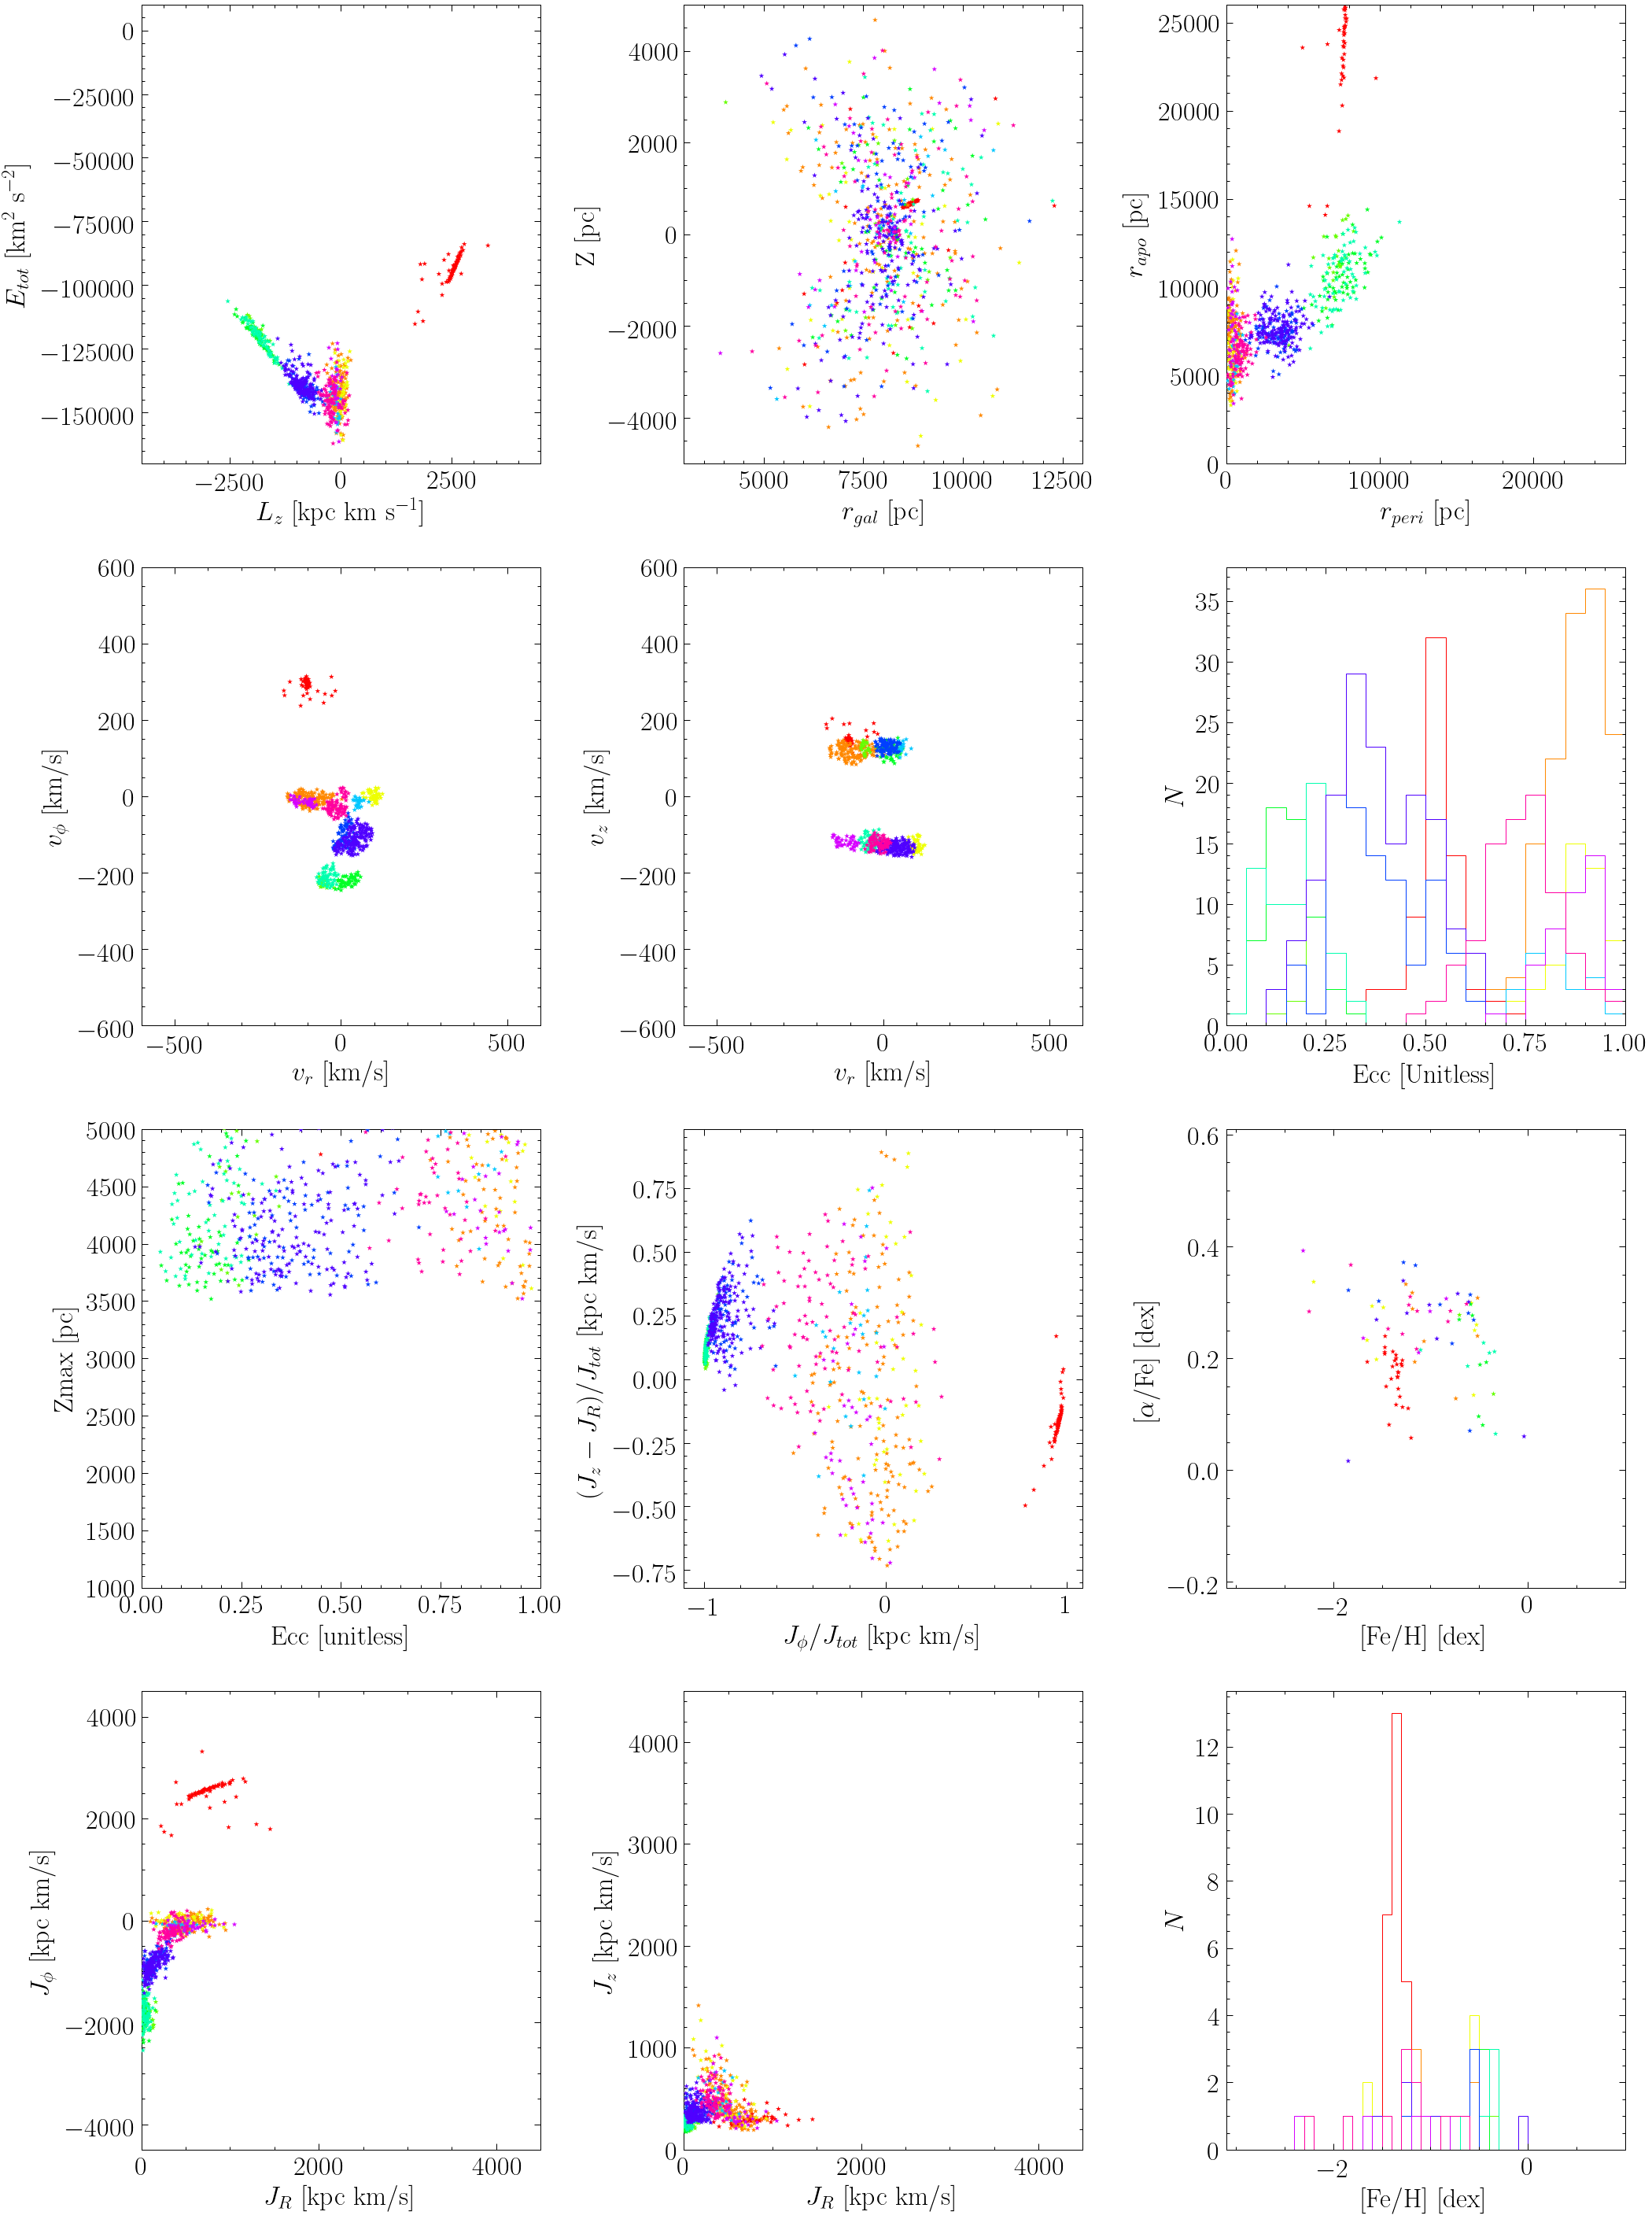

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


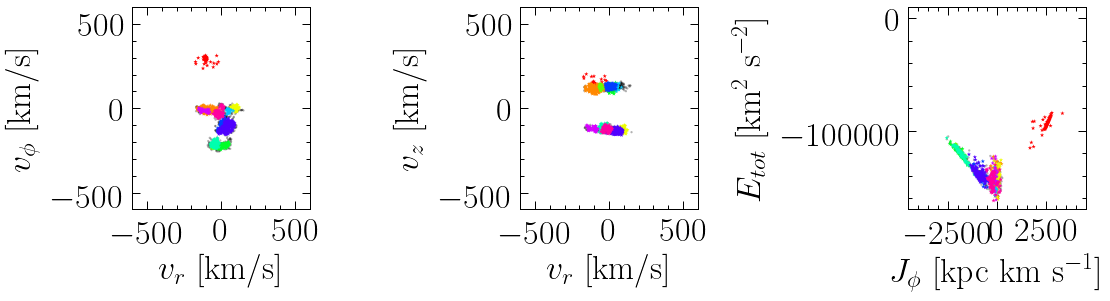

In [122]:
# Apply HDBSCAN
clust = hdbscan.HDBSCAN(min_samples=min_samples,
                        min_cluster_size=min_cluster_size,  
                        gen_min_span_tree=True, 
                        cluster_selection_method=cluster_selection_method).fit(X)
labels = clust.labels_ #[clust.ordering_]

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_clusters_stars_ = 0
for i in range(len(set(labels))):
    n_clusters_stars_ += list(labels).count(i)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number stars in clusters: %d' % n_clusters_stars_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))



# ###########################################################################

# Black removed and is used for noise instead.
unique_labels = set(labels)
print("unique_labels are", unique_labels)

colors = [plt.cm.hsv(each)
          for each in np.linspace(0, 1, len(unique_labels))]
# colors = [cmap(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# Make the color list regardless of the number of clusters and cut it to the desired length
# colors = [cmap(each)
#           for each in np.linspace(0, 1, n_clusters_estimated)][:len(unique_labels)]




# Make an empty list to save the indices
mask_list = []
col_list = []
lab_list = []
id_list = []

# Make a separate source_id array for later extraction
# Used to accomodate situations where we have additional cuts on top of the 
# initial quality cut
ind_add_cut = ind_cut[:]
X_source_id = df_cut_vel.loc[ind_add_cut,'source_id']
# ind_add_cut = ind_cut[ind_slct_PCA_least]
# X_source_id = df_cut_vel.loc[ind_add_cut,'source_id']


for k, col in zip(unique_labels, colors):
    print("k is", k)
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.3]

    class_member_mask = (labels == k)

    
    mask = class_member_mask
    anti_mask = class_member_mask
    
    xy = X[mask]
    cluster_means[k] = np.mean(xy, axis = 0)
    cluster_dispersions[k] = np.std(xy, axis = 0)
    cluster_nstars[k] = len(X[class_member_mask])
    
    # Record the indices and colors
    mask_list.append(ind_add_cut[mask])
    id_list.append(X_source_id[mask].values)
    col_list.append(np.array(col*len(X[mask])).reshape((len(X[mask]),4)))
    lab_list.append(str(k))


print("Shape of member stars", np.shape(mask_list))
np.save(data_dir + 'member_mask' + extratext + '.npy', mask_list)
np.save(data_dir + 'member_gedr3id' + extratext + '.npy', id_list)
np.save(data_dir + 'color' + extratext + '.npy', colors)


# Generate the hierarchical tree if HDBSCAN
f = plt.figure(figsize=[20,10])
clust.condensed_tree_.plot(select_clusters=True, selection_palette=colors[:-1])
tree_df = clust.condensed_tree_.to_pandas()
tree_df.to_pickle(data_dir + 'tree' + extratext + '.pkl',compression=None)

f.savefig(plot_dir + 'clustering' + extratext + '_tree' + '.pdf')

# Plot result (my summary)
matplotlib.rc('font', size=label_size+10)
if n_noise_ == 0:
    plot_summary_v3(df_cut_vel,df_cut_orb,ind_list=mask_list,c_list=col_list,
                    title=extratext,legends=lab_list,list_mask=False,ind_add_cut=ind_add_cut,ds=False,noise=False,
                    filename=plot_dir + 'clustering' + extratext + '_summary_v3.pdf')
    plot_summary_v3(df_cut_vel,df_cut_orb,ind_list=mask_list,c_list=col_list,
                    title=extratext,legends=lab_list,list_mask=False,ind_add_cut=ind_add_cut,ds=False,noise=False,
                    filename=plot_dir + 'clustering' + extratext + '_summary_v3_no_noise.pdf')
else:
    plot_summary_v3(df_cut_vel,df_cut_orb,ind_list=mask_list,c_list=col_list,
                    title=extratext,legends=lab_list,list_mask=False,ind_add_cut=ind_add_cut,ds=False,
                    filename=plot_dir + 'clustering' + extratext + '_summary_v3.pdf')
    plot_summary_v3(df_cut_vel,df_cut_orb,ind_list=mask_list[:-1],c_list=col_list[:-1],
                    title=extratext,legends=lab_list[:-1],list_mask=False,ind_add_cut=ind_add_cut,ds=False,noise=False,
                    filename=plot_dir + 'clustering' + extratext + '_summary_v3_no_noise.pdf')

plot_summary_short(df_cut_vel,df_cut_orb,ind_list=mask_list,c_list=col_list,
                title=extratext,legends=lab_list,list_mask=False,ind_add_cut=ind_add_cut,ds=False,
                filename=plot_dir + 'clustering' + extratext + '_summary_short.pdf')

In [199]:
ind_cut

array([    800,    3612,   28316,   29023,   38578,   44634,   50586,
        465350,  466948,  474563,  529896,  531429,  538520,  556000,
        557259,  648038,  649697,  675644,  685961,  692835,  699221,
        699525,  708467,  711365,  718250,  719543,  723512,  727832,
        732583,  735173,  746598,  752421,  753447,  762994,  764936,
        770147,  772148,  772344,  774249,  775447,  780638,  790412,
        790797,  791204,  796865,  801490,  802346,  804907,  805110,
        812493,  818491,  818974,  822271,  822351,  824625,  825129,
        830284,  835161,  839661,  840514,  844169,  844472,  855710,
        856757,  858257,  862757,  874334,  895138,  903032,  912517,
        929372, 1091643, 1139894, 1146907, 1205060, 1278787, 1299428,
       1379565, 1385183, 1402948, 1526047, 1701064, 1715215, 1720473,
       1726967, 1737504, 1741639, 1756068, 1768537, 1768850, 1769279,
       1773097, 1773521, 1773903, 1775464, 1779017, 1780108, 1780911,
       1785442, 1788

In [190]:
test_df = clust.condensed_tree_.to_pandas()
test_df[test_df['child_size'] > 1]

parent  child  lambda_val  child_size
0      338    339    0.122879          29
1      338    340    0.122879         309
3      340    341    0.174689          47
4      340    342    0.174689         262
13     342    343    1.407592         120
14     342    344    1.407592         140

In [195]:
test2_df = clust.single_linkage_tree_.to_pandas()
test2_df

parent  left_child  right_child  distance   size
0       338       100.0        331.0  0.205847    2.0
1       339       301.0        338.0  0.207692    3.0
2       340       209.0        339.0  0.211072    4.0
3       341       147.0        340.0  0.212799    5.0
4       342       153.0        341.0  0.213300    6.0
..      ...         ...          ...       ...    ...
332     670       219.0        669.0  2.236027   28.0
333     671       123.0        670.0  2.244416   29.0
334     672       109.0        668.0  3.442752   47.0
335     673       672.0        601.0  5.724446  309.0
336     674       671.0        673.0  8.138073  338.0

[337 rows x 5 columns]

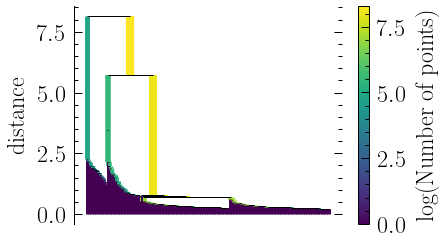

In [194]:
clust.single_linkage_tree_.plot()

In [198]:
clust.single_linkage_tree_.get_clusters(0.2, min_cluster_size=15)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [1369]:
import sys
sys.getsizeof(test_df)

73216

In [1365]:
# Examine the numbers
print(f'The total number of stacked stars at this cut is: {np.shape(X)[0]}')
# print(f'Number of noise: {}')

The total number of stacked stars at this cut is: 2263


In [1366]:
colors

[(1.0, 0.0, 0.0, 1.0),
 (1.0, 0.532721120956415, 0.0, 1.0),
 (0.93455775808717, 1.0, 0.0, 1.0),
 (0.4018366371307548, 1.0, 0.0, 1.0),
 (0.0, 1.0, 0.15404569495487538, 1.0),
 (0.0, 1.0, 0.6867634597860162, 1.0),
 (0.0, 0.7805173926497455, 1.0, 1.0),
 (0.0, 0.24779627169333063, 1.0, 1.0),
 (0.30808663713075457, 0.0, 1.0, 1.0),
 (0.8408077580871701, 0.0, 1.0, 1.0),
 (1.0, 0.0, 0.6264711209564149, 1.0),
 (1.0, 0.0, 0.09375, 1.0)]

[1. 0. 0. 1.] 92


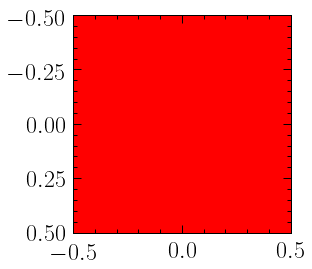

[1.         0.53272112 0.         1.        ] 26


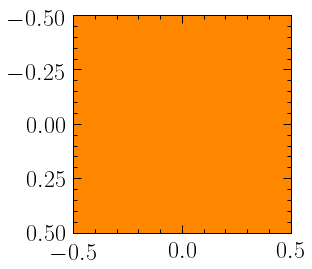

[0.93455776 1.         0.         1.        ] 46


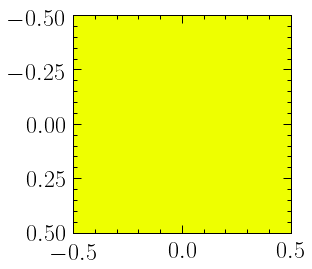

[0.40183664 1.         0.         1.        ] 101


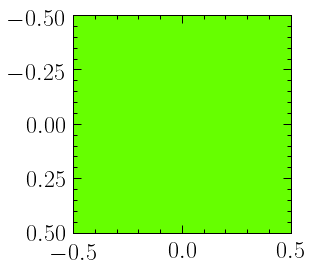

[0.         1.         0.15404569 1.        ] 37


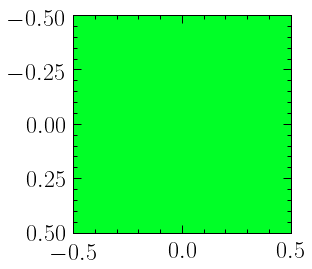

[0.         1.         0.68676346 1.        ] 88


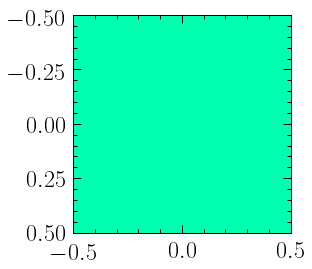

[0.         0.78051739 1.         1.        ] 70


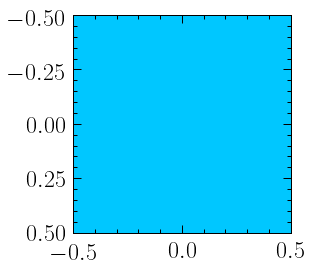

[0.         0.24779627 1.         1.        ] 38


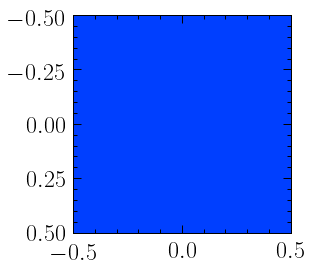

[0.30808664 0.         1.         1.        ] 44


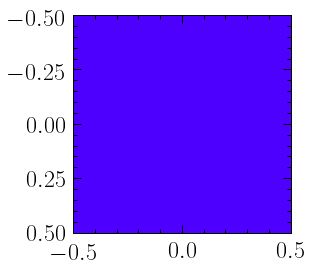

[0.84080776 0.         1.         1.        ] 100


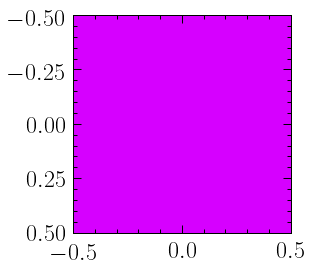

[1.         0.         0.62647112 1.        ] 64


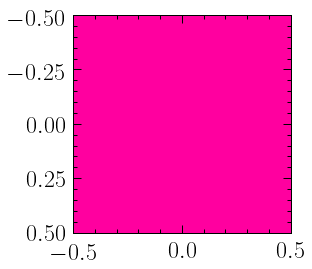

[0.  0.  0.  0.3] 1557


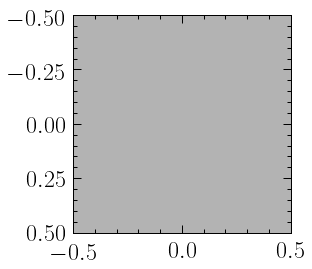

In [1367]:
# Double check the colors
for i in range(len(unique_labels)):
    print(col_list[i][0],len(col_list[i]))
    plt.imshow([[col_list[i][0]]])
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6743: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))


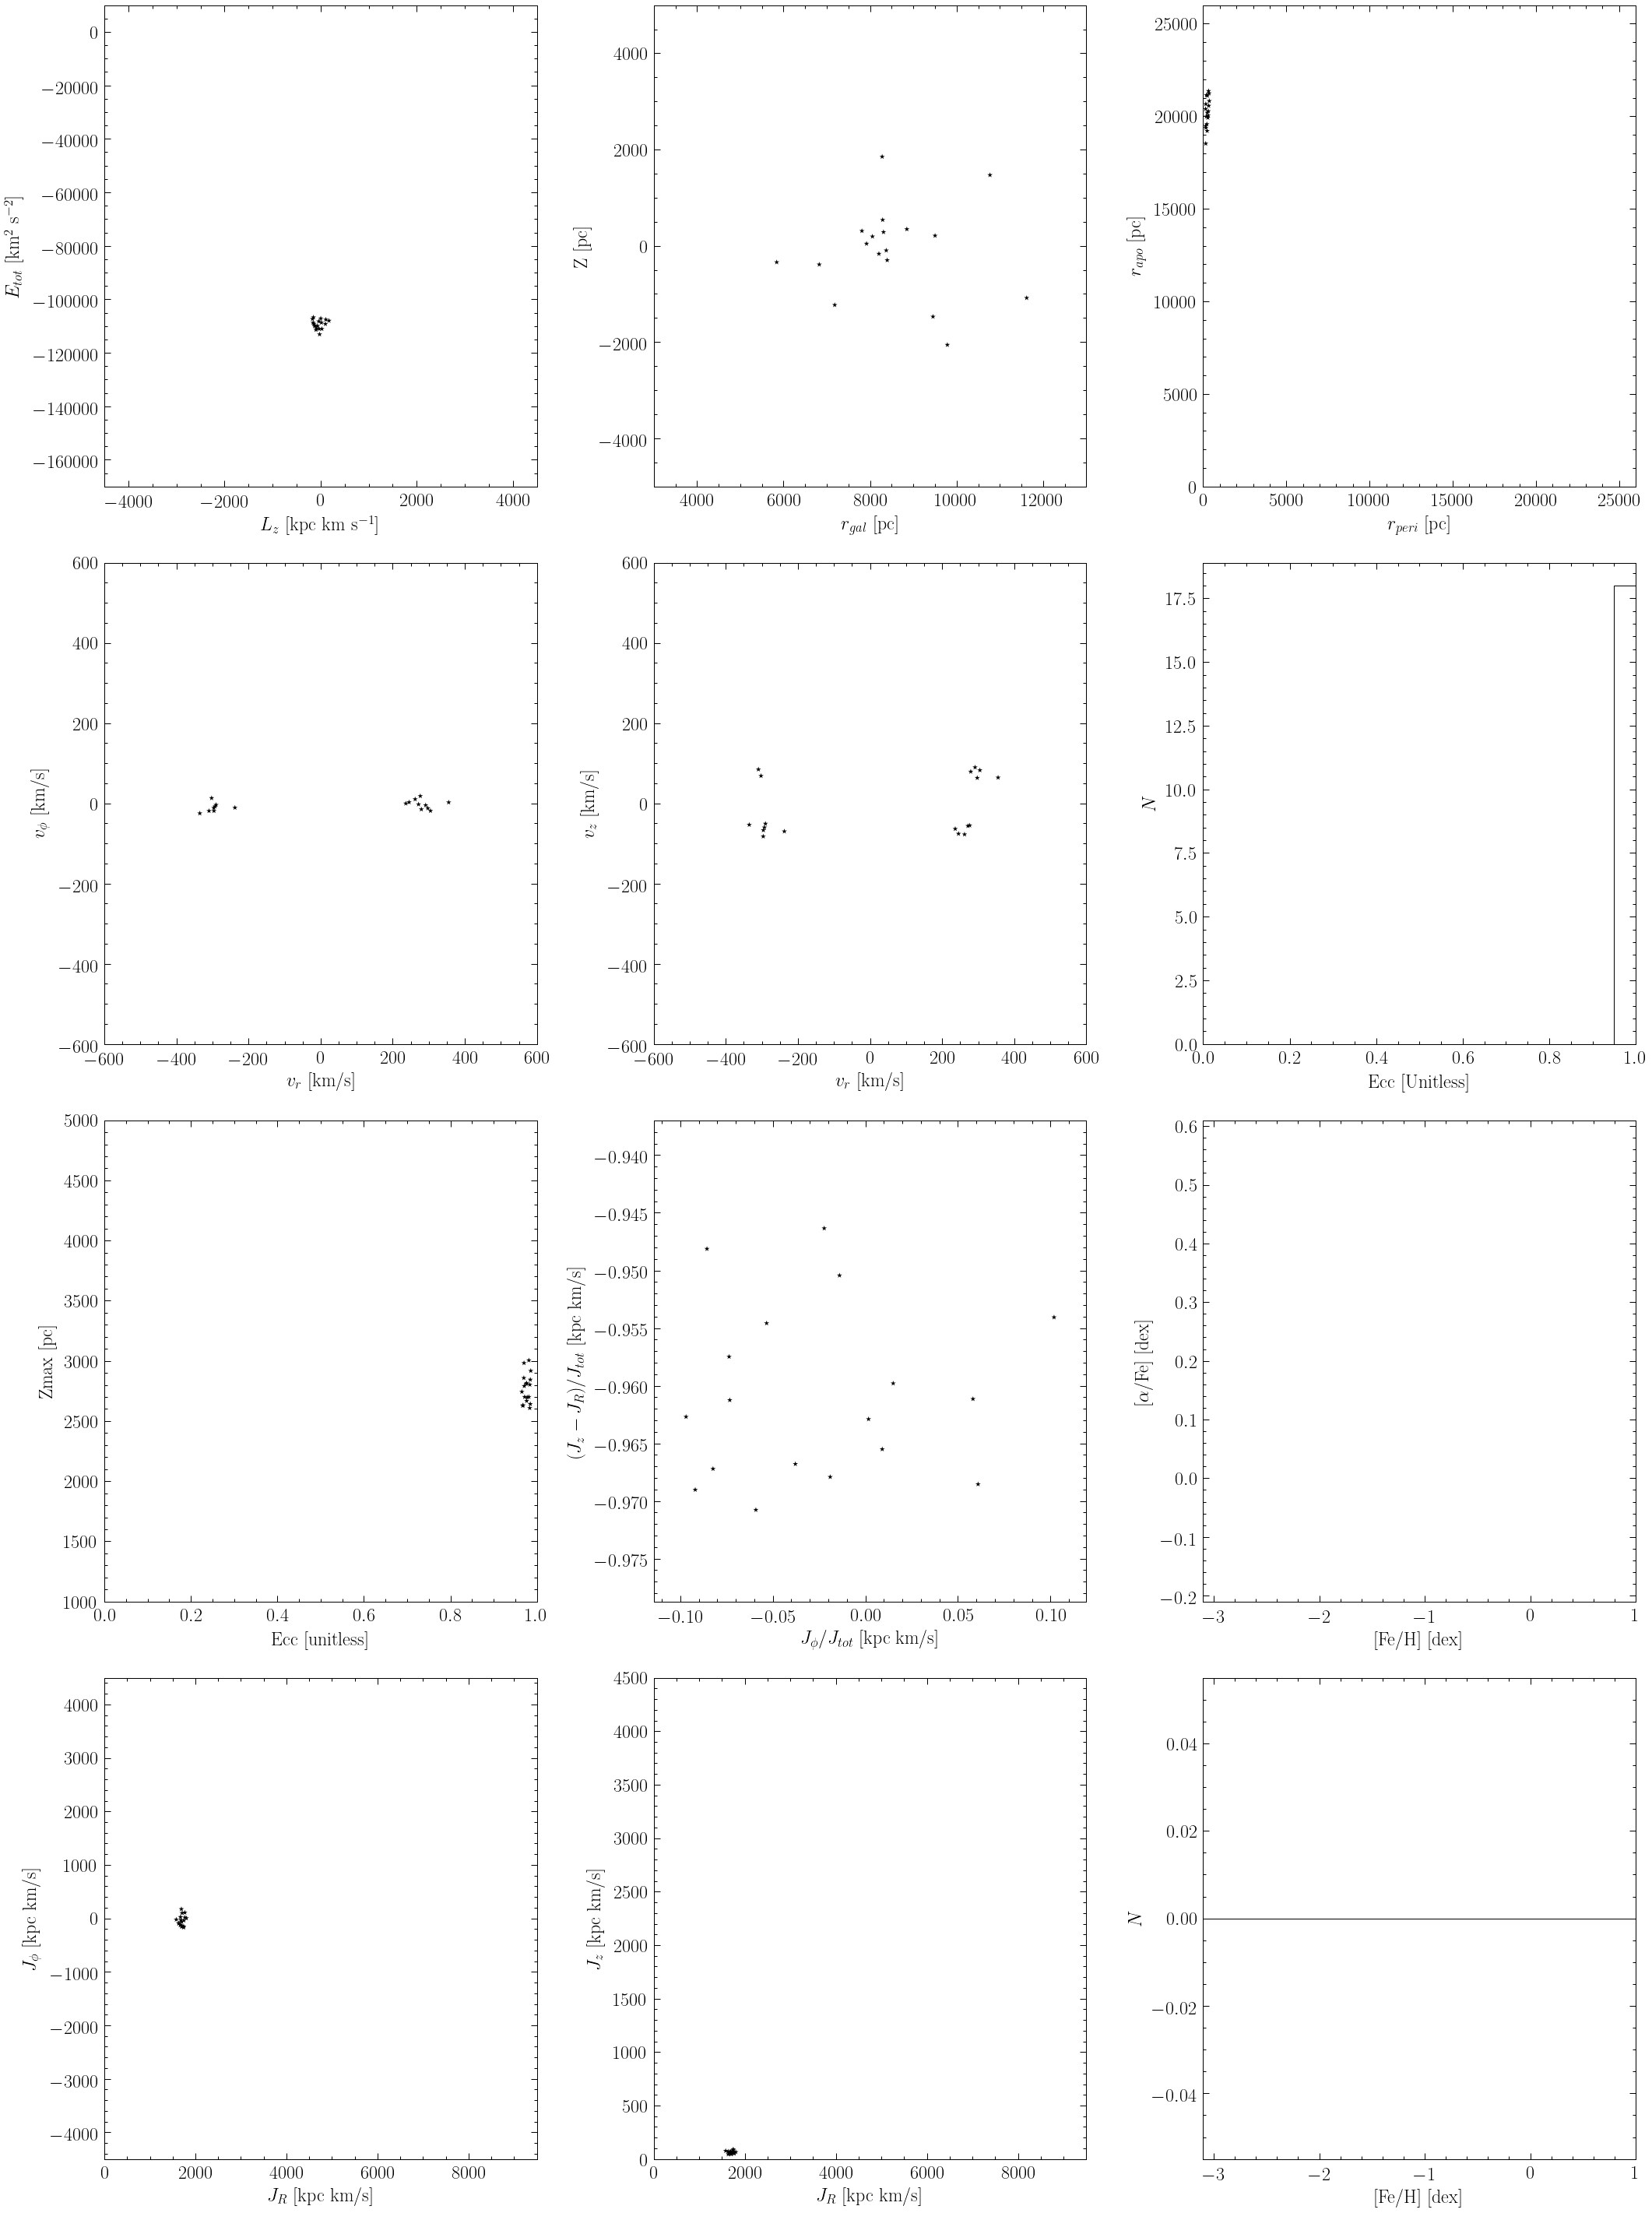

In [1140]:
i = 3
plot_summary_v3(df_cut_vel,df_cut_orb,ind_list=[mask_list[i]],c_list=[col_list[i]],
                title=extratext,legends=[lab_list[i]],list_mask=False,ind_add_cut=ind_add_cut,ds=False,
                filename=None)

In [991]:
cm_vel_all.columns

Index(['index', 'source_id', 'ra', 'dec', 'm_h_ap', 'm_h_err_ap', 'm_h_flg_ap',
       'alpha_m_ap', 'alpha_m_err_ap', 'alpha_m_flg_ap', 'm_h_l6s',
       'm_h_err_l6s', 'm_h_flg_l6s', 'alpha_m_l6s', 'alpha_m_err_l6s',
       'alpha_m_flg_l6s', 'm_h_gl3', 'm_h_err_gl3', 'm_h_flg_gl3',
       'alpha_m_gl3', 'alpha_m_err_gl3', 'alpha_m_flg_gl3', 'm_h_r6',
       'alpha_m_r6', 'm_h_err_r6', 'alpha_m_err_r6', 'XGC', 'YGC', 'ZGC',
       'm_h_r6c', 'alpha_m_r6c', 'm_h_err_r6c', 'alpha_m_err_r6c',
       'm_h_flg_r6c', 'alpha_m_flg_r6c', 'qual_flag', 'bin_flag', 'parallax',
       'parallax_error', 'parallax_zpcorr', 'l', 'b', 'XGCerr', 'YGCerr',
       'ZGCerr', 'U_g2', 'Uerr_g2', 'V_g2', 'Verr_g2', 'W_g2', 'Werr_g2',
       'UVcov_g2', 'UWcov_g2', 'VWcov_g2', 'v_forder_g2', 'vr_g2', 'vphi_g2',
       'vz_g2', 'vrerr_g2', 'vphierr_g2', 'vzerr_g2', 'vrphicov_g2',
       'vrzcov_g2', 'vphizcov_g2', 'm_h_ap17', 'm_h_err_ap17', 'alpha_m_ap17',
       'alpha_m_err_ap17', 'aspcap_flg_ap17', 'N_in

In [997]:
print(cm_vel_all.loc[mask_list[8],['ra','dec']].values)

[[ 2.92751125e+01  1.45587785e+01]
 [ 5.00281188e+00  4.99273495e+01]
 [ 4.21078909e+01  6.28975501e+01]
 [ 1.43711005e+02  1.46905940e+01]
 [ 1.44081306e+02  2.74653310e+01]
 [ 1.67807882e+02  3.02549043e+01]
 [ 1.72467425e+02  5.47959924e+01]
 [ 1.23505718e+02  3.94858136e+01]
 [ 1.00302137e+02  3.09678222e+01]
 [ 1.40218453e+02  5.78981971e+01]
 [ 2.25733316e+02  1.00518045e+01]
 [ 2.26645068e+02  2.05291521e+01]
 [ 2.52407800e+02  3.07037102e+01]
 [ 2.44149691e+02  3.59018375e+01]
 [ 2.64843539e+02  4.69465711e+01]
 [ 2.33944734e+02  3.66962943e+01]
 [ 2.64217597e+02  5.67291116e+01]
 [ 2.10035116e+02  2.85872814e+01]
 [ 1.85105869e+02  4.08654416e+01]
 [ 2.22989137e+02  6.68623235e+01]
 [ 1.94867433e+02  7.62011903e+01]
 [ 3.18860923e+02  1.06649405e+01]
 [ 3.20884625e+02  1.02817912e+01]
 [ 3.17216139e+02  3.62598075e+01]
 [ 3.48502379e+02  3.00209832e+01]
 [ 3.38977709e+02  2.98757274e+01]
 [ 2.93210453e+02  4.25253006e+01]
 [ 2.88272180e+02  5.76740450e+01]
 [ 3.29546830e+02  5

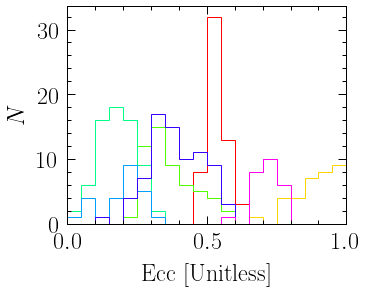

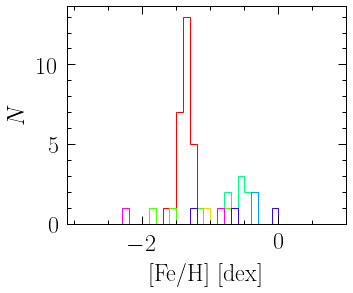

In [694]:
# Make 1-D histograms for metallicity and eccentricity
f = plt.figure(figsize=[5,4])

for i in range(len(unique_labels)-1):
    plt.hist(df_cut_orb.loc[mask_list[i],'ecc'],histtype='step',bins=np.arange(0.0,1.05,0.05),color=col_list[i][0])

plt.xlabel(r'Ecc [Unitless]')
plt.xlim([0,1])
plt.ylabel(r'$N$')
plt.show()
f.savefig(plot_dir + 'clustering' + extratext + '_ecc_hist.pdf')

f = plt.figure(figsize=[5,4])

for i in range(len(unique_labels)-1):
    plt.hist(df_cut_vel.loc[mask_list[i],'m_h_mean'],histtype='step',bins=np.arange(-3.1,1.1,0.1),color=col_list[i][0])

plt.xlabel(r'[Fe/H] [dex]')
plt.xlim([-3.1,1.0])
plt.ylabel(r'$N$')
plt.show()
f.savefig(plot_dir + 'clustering' + extratext + '_fe_h_hist.pdf')


In [539]:
# Now process the stars data for feeding into approximate_predict
# Add in the dimensions as needed 
s_ydata_ini = []
s_ydata_ini_err = []

s_X = RobustScaler().fit(ydata_samp).transform(s_ydata)

pred_labels, pred_strengths = hdbscan.approximate_predict(clust, s_X)

s_col_list = [cmap(col)[0:3]+ (sat,) for col, sat in zip(pred_labels, pred_strengths)]

s_col_list_robust = np.copy(s_col_list)

for i in range(len(pred_labels)):
    if pred_labels[i] in np.arange(len(mask_not_robust))[mask_not_robust]:
        s_col_list_robust[i,3] = 0.

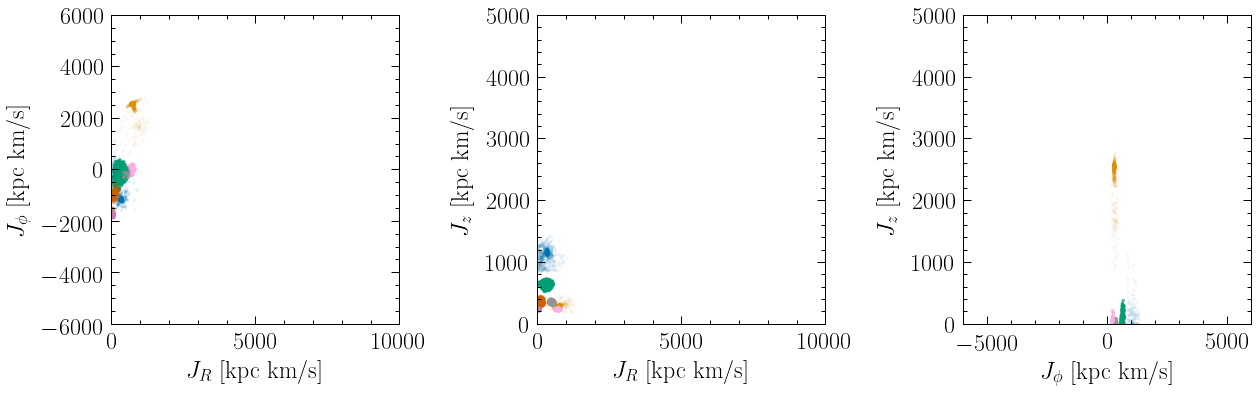

In [540]:
# Plot all clusters of clusters, as well as the stars predicted
# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$v_{R}$ [km/s]', r'$v_{R}$ [km/s]', r'$v_{z}$ [km/s]'], 
#               y_label=[r'$v_{\phi}$ [km/s]', r'$v_{z}$ [km/s]', r'$v_{\phi}$ [km/s]'], 
#               xlim_l=[-400]*3, xlim_u=[400]*3, 
#               ylim_l=[-400]*3, ylim_u=[400]*3, 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
#               add_data=s_ydata, add_err=[], add_c_list=s_col_list,
#               x_ax = [0,0,2], y_ax = [1,2,1], 
#               err_bar = False , f_name=plot_dir+'hdbscan_on_cluster_all_w_pred.pdf')

plot_clusters(mean_comb, disp_comb, 
              x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]'], 
              y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]'], 
              xlim_l=[0,0,-6000], xlim_u=[10000,10000,6000], 
              ylim_l=[-6000,0,0], ylim_u=[6000,5000,5000], 
              fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
              add_data=s_ydata, add_err=[], add_c_list=s_col_list,
              x_ax = [0,0,2], y_ax = [1,2,1], 
              err_bar = False , f_name=plot_dir+'hdbscan_on_cluster_all_w_pred.pdf')

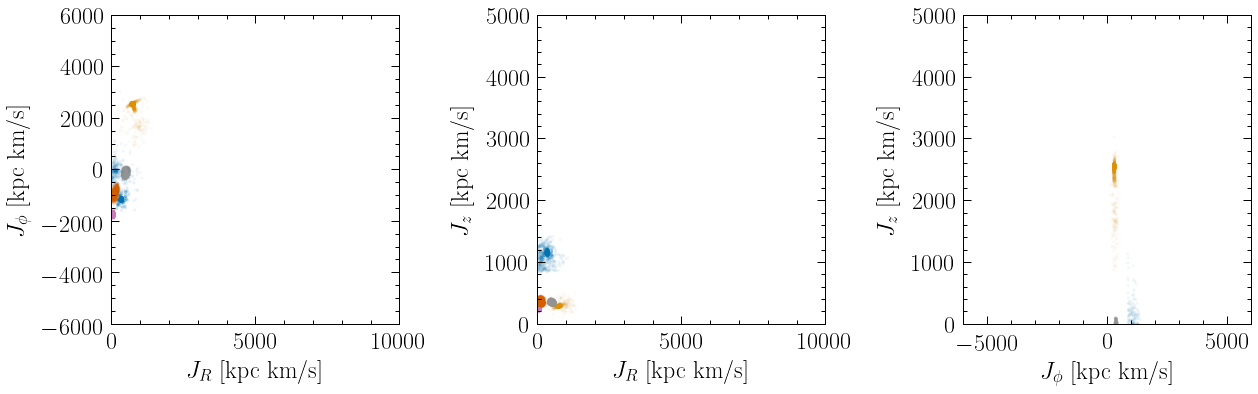

In [541]:
# Plot only robust clusters of clusters, as well as the stars predicted to be part of robust clusters
# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$v_{R}$ [km/s]', r'$v_{R}$ [km/s]', r'$v_{z}$ [km/s]'], 
#               y_label=[r'$v_{\phi}$ [km/s]', r'$v_{z}$ [km/s]', r'$v_{\phi}$ [km/s]'], 
#               xlim_l=[-400]*3, xlim_u=[400]*3, 
#               ylim_l=[-400]*3, ylim_u=[400]*3, 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list_robust,
#               add_data=s_ydata, add_err=[], add_c_list=s_col_list_robust,
#               x_ax = [0,0,2], y_ax = [1,2,1], 
#               err_bar = False , f_name=plot_dir+'hdbscan_on_cluster_robust_w_pred.pdf')

plot_clusters(mean_comb, disp_comb, 
              x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]'], 
              y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]'], 
              xlim_l=[0,0,-6000], xlim_u=[10000,10000,6000], 
              ylim_l=[-6000,0,0], ylim_u=[6000,5000,5000], 
              fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list_robust,
              add_data=s_ydata, add_err=[], add_c_list=s_col_list_robust,
              x_ax = [0,0,2], y_ax = [1,2,1], 
              err_bar = False , f_name=plot_dir+'hdbscan_on_cluster_robust_w_pred.pdf')

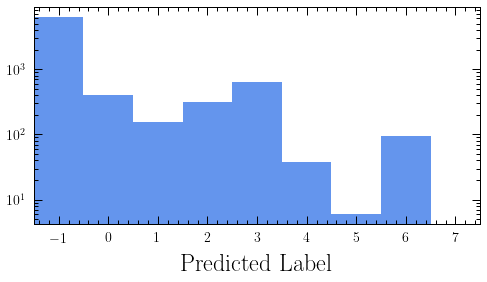

In [542]:
# Characterize the star prediction result
f, ax = plt.subplots(figsize=[8,4])
plt.hist(pred_labels,bins=np.arange(-1.5,n_clusters_-0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20,integer=True))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlim([-1.5,n_clusters_-0.5])
plt.xlabel('Predicted Label')
plt.show()
f.savefig(plot_dir+'hdbscan_on_cluster_pred_label_hist.pdf')

In [543]:
# Count predicted noise
print('Number of stars predicted as noise:'+str(len(pred_strengths[pred_labels == -1])))

# Count predicted noise + in non-robust cluster 
count = len(pred_strengths[pred_labels == -1])
for i in ind_not_robust:
    print(len(pred_strengths[pred_labels == i]))
    count += len(pred_strengths[pred_labels == i])
print('Number of stars predicted as noise or in a not robust cluster:',count)
# print(len(pred_strengths[(pred_labels in ([-1] + list(ind_not_robust)))]))

Number of stars predicted as noise:6389
311
6
95
Number of stars predicted as noise or in a not robust cluster: 6801


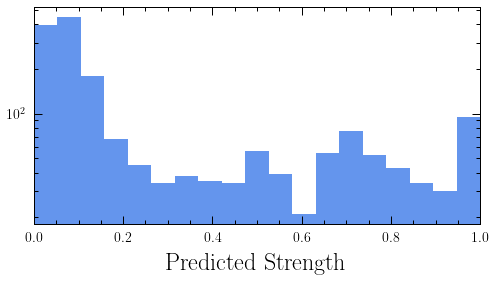

In [544]:
# Examine the prediction strength, excluding all the stars predicted as noise, which always have strength = 0
f, ax = plt.subplots(figsize=[8,4])
plt.hist(pred_strengths[pred_labels != -1],bins=np.linspace(0,1,20))
plt.yscale('log')
# ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20,integer=True))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,1])
plt.xlabel('Predicted Strength')
plt.show()
f.savefig(plot_dir+'hdbscan_on_cluster_pred_stren_hist.pdf')

In [545]:
print(np.shape(pred_labels),np.shape(pred_strengths))
print(pred_labels[0:10],pred_strengths[0:10])

(8166,) (8166,)
[-1 -1 -1  4 -1 -1 -1 -1 -1 -1] [0.         0.         0.         0.34330843 0.         0.
 0.         0.         0.         0.        ]


In [546]:
print(len(np.arange(len(mask_not_robust))[mask_not_robust]))

3


In [547]:
for i in np.arange(len(mask_not_robust))[mask_not_robust]:
    print(i)

2
5
6


In [17]:
print(cluster_ncluts)

[101. 100.  40.  80.  24.  23.  27.  39. 115.  32.  61.  34.  35.  59.
  29. 109.  42.  26. 180.  28. 112.  76.  24. 127. 104. 117. 120.  96.
  45.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 608.]


In [553]:
# Examine where the clusters came from with a histogram?
i_cluster_to_check = 7
clust_comp = clust_lbl_comb[mask_list[i_cluster_to_check]]
print(len(clust_comp))
print(cluster_means[i_cluster_to_check])


count_res = Counter(clust_comp)
print(count_res.most_common())

79
[ 505.44643678 -139.72875207  344.82139277]
[(60, 2), (96, 2), (0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (11, 1), (12, 1), (15, 1), (17, 1), (18, 1), (19, 1), (21, 1), (23, 1), (24, 1), (26, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (35, 1), (36, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (61, 1), (64, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (83, 1), (84, 1), (86, 1), (87, 1), (88, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (97, 1), (98, 1), (99, 1)]


In [554]:
# Examine the disk-like properties of the robust clusters
mask_robust = ~(cluster_ncluts[0:n_clusters_] < 70)

for i in np.arange(len(mask_robust))[mask_robust]:
    print(i,cluster_means[i])

0 [ 307.50840375 -968.77557889 1141.02355729]
1 [ 760.7111001  2449.81650416  289.98533205]
3 [ 105.53188275 -928.72644848  349.43207012]
4 [   62.03544177 -1755.40469163   234.81963513]
7 [ 505.44643678 -139.72875207  344.82139277]
